In [1]:
# -*- coding: utf-8 -*-

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import time
import math
import random
import pandas as pd
import scipy.signal
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as dist
from data_prepare_for_many import *
#from data_prepare_nobehavior import *

torch.manual_seed(1)

MAX_LENGTH = 100
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('ok')
length = 31
predict_length = 30
batch_size = 128
file_path_train = np.array(glob('data/data_interactive/train/*'))
file_path_test = np.array(glob('data/data_interactive/test/*'))
file_path_valid = np.array(glob('data/data_interactive/valid/*'))
#Training_generator1, Test, Valid, WholeSet= get_dataloader(batch_size,length,predict_length)
Training_generator,WholeSet_train= get_dataloader(batch_size,length,predict_length,file_path_train,'train')
Test,WholeSet= get_dataloader(batch_size,length,predict_length,file_path_test,'test')
Valid, WholeSet_valid = get_dataloader(batch_size,length,predict_length,file_path_valid,'valid')
class TraPred(nn.Module):
    def __init__(self, input_size, output_size,hidden_size,batch_size, dropout=0.5):
        super(TraPred, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.in2lstm = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,num_layers=self.num_layers,bidirectional=False,batch_first=True,dropout =dropout)
        self.in2bilstm = nn.Linear(input_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2,num_layers=self.num_layers,bidirectional=True,batch_first=True,dropout =dropout)
    
        self.fc0 = nn.Linear(hidden_size,hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2,int(hidden_size/2))
        self.in2out = nn.Linear(input_size, int(hidden_size/2))
        self.fc2 = nn.Linear(int(hidden_size/2) ,output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        #input = tensor shape[batchsize, len, num_features]
        bilstm_out,_= self.bilstm(self.in2bilstm(input))
        lstm_out,_= self.lstm(self.in2lstm(input))
        out = self.tanh(self.fc0(lstm_out+bilstm_out))
        out = self.tanh(self.fc1(out))
        out =  out + self.in2out(input)
        output = self.fc2(out)# range [0 -> 1 ]
        return output

ok
****************************************************************************************************
训练轨迹轨迹条数： 384866
---轨迹输入数据结构： torch.Size([128, 31, 43]) ---轨迹输出数据结构： torch.Size([128, 31, 4])
---轨迹长度： 31 ---预测轨迹长度： 30
****************************************************************************************************
测试轨迹轨迹条数： 12031
---轨迹输入数据结构： torch.Size([128, 31, 43]) ---轨迹输出数据结构： torch.Size([128, 31, 4])
---轨迹长度： 31 ---预测轨迹长度： 30
****************************************************************************************************
验证轨迹轨迹条数： 35913
---轨迹输入数据结构： torch.Size([128, 31, 43]) ---轨迹输出数据结构： torch.Size([128, 31, 4])
---轨迹长度： 31 ---预测轨迹长度： 30


In [2]:
def normalize_data(data):
    data = np.asarray(data.cpu())
    data = torch.from_numpy(data)
    for i in range(data.shape[0]):
        A = np.array(data[i]).astype(np.float64)
        A = torch.from_numpy(A)
        mn = torch.mean(A, dim=0)
        rg = (torch.max(A, dim=0).values - torch.min(A, dim=0).values) / 2.0
        rg = torch.ones(rg.shape, dtype=torch.double)
        std = torch.std(A, dim=0)
        for j in range(std.size(0)):
            if std[j] == 0:
                std[j] = 1
        data[i] = (data[i] - mn) / (std * rg)
    data = np.asarray(data).astype(np.float64)
    data = torch.from_numpy(data)
    return (data)

In [4]:
def trainIters(encoder, epoches,learning_rate=0.0001,print_every=7):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer,mode='min',
factor=0.1, patience=120,verbose=True,threshold=0.0001,threshold_mode='rel',cooldown=0,min_lr=0,eps=1e-015)
    #criterion = nn.MSELoss(reduction='sum')
    criterion = nn.MSELoss()
    loss_min = np.inf
    train_losses =[]
    valid_losses =[]
    encoder.train()
    for e in range(1, epoches + 1):
        train_loss = []
        for batch_i,(local_batch, local_labels) in enumerate(Training_generator):
            encoder.zero_grad()
#             local_batch = normalize_data(local_batch)
#             local_labels = normalize_data(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            
            predY = encoder(local_batch)
            loss = criterion(predY,local_labels).to(device)
            loss.backward()
            encoder_optimizer.step()
            train_loss.append(loss.item())
            if batch_i % print_every == 0:     
                valid_loss = []
                encoder.eval()
                for x,y in Valid:
#                     x = normalize_data(x)
#                     y = normalize_data(y)
                    x,y = x.to(device),y.to(device)
                    predict = encoder(x)
                    loss_valid = criterion(predict,y)
                    valid_loss.append(loss_valid.item())
                encoder.train()
                train_loss_mean = np.mean(train_loss)
                valid_loss_mean = np.mean(valid_loss)
                train_losses.append(train_loss_mean)
                valid_losses.append(valid_loss_mean)
                scheduler.step(valid_loss_mean)
                print("Epoch:{}/{},Step:{}/{}".format(e,epoches,batch_i,len(Training_generator)),
                  "Train_Loss:{},Valid_Loss: {}".format(train_loss_mean,valid_loss_mean))
                if valid_loss_mean < loss_min :                             
                    print("valid_loss decrease!!!save the model.")
                    loss_min = valid_loss_mean
                    torch.save(encoder.state_dict(),'model/trajectory_predict_0114_43_4_30_new.pt')
                #torch.save(encoder.state_dict(),'model/trajectory_predict_68_4_30_each.pt')
    plt.plot(train_losses,color = 'r',label = 'Train_Loss')
    plt.plot(valid_losses,color = 'g',label = 'Valid_Loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('image/trajectory_loss_0114_43_4_30.svg',dpi=600)

In [5]:
train_iter = iter(Training_generator)
x, y = train_iter.next()
print(x.shape, y.shape)
hidden_size = 64
drop = 0.5
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0],drop)

torch.Size([128, 31, 43]) torch.Size([128, 31, 4])


In [6]:
from time import time
TRAN_TAG = True
if TRAN_TAG:
    if path.exists("model/trajectory_predict_0114_43_4_30_new.pt"):
        Prednet.load_state_dict(torch.load('model/trajectory_predict_0114_43_4_30_new.pt'))
    Prednet = Prednet.double()
    Prednet = Prednet.to(device)
    start = time()
    trainIters(Prednet, 20,0.001,20)
    print('Training time is:',time()-start,'s')

Epoch:1/20,Step:0/3007 Train_Loss:1.135769700124537,Valid_Loss: 1.091661340699962
valid_loss decrease!!!save the model.
Epoch:1/20,Step:20/3007 Train_Loss:0.771169112245298,Valid_Loss: 0.34461813666794944
valid_loss decrease!!!save the model.
Epoch:1/20,Step:40/3007 Train_Loss:0.5137840641065299,Valid_Loss: 0.15621610657858837
valid_loss decrease!!!save the model.
Epoch:1/20,Step:60/3007 Train_Loss:0.3835314421295489,Valid_Loss: 0.07025755135515283
valid_loss decrease!!!save the model.
Epoch:1/20,Step:80/3007 Train_Loss:0.30534229549187325,Valid_Loss: 0.05183415991799423
valid_loss decrease!!!save the model.
Epoch:1/20,Step:100/3007 Train_Loss:0.2551878254867513,Valid_Loss: 0.04350011675431656
valid_loss decrease!!!save the model.
Epoch:1/20,Step:120/3007 Train_Loss:0.22072339902382315,Valid_Loss: 0.03906479886779848
valid_loss decrease!!!save the model.
Epoch:1/20,Step:140/3007 Train_Loss:0.19545784035137406,Valid_Loss: 0.03651439058545942
valid_loss decrease!!!save the model.
Epoch:1

Epoch:1/20,Step:1420/3007 Train_Loss:0.03833474826858659,Valid_Loss: 0.012691351514771665
valid_loss decrease!!!save the model.
Epoch:1/20,Step:1440/3007 Train_Loss:0.03802392858067536,Valid_Loss: 0.012359160952606035
valid_loss decrease!!!save the model.
Epoch:1/20,Step:1460/3007 Train_Loss:0.03769774112748903,Valid_Loss: 0.012801160045226863
Epoch:1/20,Step:1480/3007 Train_Loss:0.03738823303251416,Valid_Loss: 0.012187084297102118
valid_loss decrease!!!save the model.
Epoch:1/20,Step:1500/3007 Train_Loss:0.037054256947728445,Valid_Loss: 0.012810645057510013
Epoch:1/20,Step:1520/3007 Train_Loss:0.036737189592772175,Valid_Loss: 0.012428751793997606
Epoch:1/20,Step:1540/3007 Train_Loss:0.03644240461202753,Valid_Loss: 0.012359143194525976
Epoch:1/20,Step:1560/3007 Train_Loss:0.03614352472837449,Valid_Loss: 0.012322244804621463
Epoch:1/20,Step:1580/3007 Train_Loss:0.03584395878065362,Valid_Loss: 0.012106644019840138
valid_loss decrease!!!save the model.
Epoch:1/20,Step:1600/3007 Train_Loss

Epoch:2/20,Step:60/3007 Train_Loss:0.011486405210728415,Valid_Loss: 0.010492902960725123
Epoch:2/20,Step:80/3007 Train_Loss:0.011145913437494867,Valid_Loss: 0.010188567954477807
Epoch:2/20,Step:100/3007 Train_Loss:0.011213605688514235,Valid_Loss: 0.01044644280599434
Epoch:2/20,Step:120/3007 Train_Loss:0.01125238154941824,Valid_Loss: 0.010552104904229523
Epoch:2/20,Step:140/3007 Train_Loss:0.01152454234047023,Valid_Loss: 0.010789925553904667
Epoch:2/20,Step:160/3007 Train_Loss:0.011655622832267822,Valid_Loss: 0.010706083821108055
Epoch:2/20,Step:180/3007 Train_Loss:0.011565011675257354,Valid_Loss: 0.010303705913930879
Epoch:2/20,Step:200/3007 Train_Loss:0.01178805335093707,Valid_Loss: 0.010802745144620679
Epoch:2/20,Step:220/3007 Train_Loss:0.011853979843818505,Valid_Loss: 0.0107429734817836
Epoch:2/20,Step:240/3007 Train_Loss:0.011786140492880227,Valid_Loss: 0.010188830779163566
Epoch:2/20,Step:260/3007 Train_Loss:0.012003451184840072,Valid_Loss: 0.010508117619647785
Epoch:2/20,Step:28

Epoch:2/20,Step:1800/3007 Train_Loss:0.010636847504966695,Valid_Loss: 0.009292924263114644
valid_loss decrease!!!save the model.
Epoch:2/20,Step:1820/3007 Train_Loss:0.01062972772104528,Valid_Loss: 0.009716458780021512
Epoch:2/20,Step:1840/3007 Train_Loss:0.010619683833341968,Valid_Loss: 0.009988142090748
Epoch:2/20,Step:1860/3007 Train_Loss:0.010602230052478533,Valid_Loss: 0.010071828325694072
Epoch:2/20,Step:1880/3007 Train_Loss:0.010589320032268952,Valid_Loss: 0.00976984530524274
Epoch:2/20,Step:1900/3007 Train_Loss:0.010586155785356176,Valid_Loss: 0.009961870514414568
Epoch:2/20,Step:1920/3007 Train_Loss:0.010594947670445163,Valid_Loss: 0.009766434402315786
Epoch:2/20,Step:1940/3007 Train_Loss:0.01060413207518787,Valid_Loss: 0.009515527454834301
Epoch:2/20,Step:1960/3007 Train_Loss:0.010592374553192337,Valid_Loss: 0.009468702674800253
Epoch:2/20,Step:1980/3007 Train_Loss:0.010576284494130147,Valid_Loss: 0.009454019476394723
Epoch:2/20,Step:2000/3007 Train_Loss:0.010563385120167395,

Epoch:3/20,Step:580/3007 Train_Loss:0.009622044662379606,Valid_Loss: 0.009157382591606174
valid_loss decrease!!!save the model.
Epoch:3/20,Step:600/3007 Train_Loss:0.009568137867585435,Valid_Loss: 0.009412121646909029
Epoch:3/20,Step:620/3007 Train_Loss:0.009524588489690657,Valid_Loss: 0.00936130387086554
Epoch:3/20,Step:640/3007 Train_Loss:0.009510227390219131,Valid_Loss: 0.009193304023891926
Epoch:3/20,Step:660/3007 Train_Loss:0.009544909243772224,Valid_Loss: 0.00923745906674217
Epoch:3/20,Step:680/3007 Train_Loss:0.00951676423288372,Valid_Loss: 0.00940931168903791
Epoch:3/20,Step:700/3007 Train_Loss:0.00957049037929168,Valid_Loss: 0.00941212337418444
Epoch:3/20,Step:720/3007 Train_Loss:0.009531540824421087,Valid_Loss: 0.009641877257549381
Epoch:3/20,Step:740/3007 Train_Loss:0.009489679919693104,Valid_Loss: 0.009082396353711279
valid_loss decrease!!!save the model.
Epoch:3/20,Step:760/3007 Train_Loss:0.009484055340942281,Valid_Loss: 0.009551582355843385
Epoch:3/20,Step:780/3007 Train

Epoch:3/20,Step:2380/3007 Train_Loss:0.00913410758607437,Valid_Loss: 0.009068798204162868
Epoch:3/20,Step:2400/3007 Train_Loss:0.00913890734782865,Valid_Loss: 0.009324583282332344
Epoch:3/20,Step:2420/3007 Train_Loss:0.009125837634157502,Valid_Loss: 0.009232073497761777
Epoch:3/20,Step:2440/3007 Train_Loss:0.009158022195018318,Valid_Loss: 0.009890527178626866
Epoch:3/20,Step:2460/3007 Train_Loss:0.00915534602138685,Valid_Loss: 0.009812183481521412
Epoch:3/20,Step:2480/3007 Train_Loss:0.0091560636078671,Valid_Loss: 0.009258437922811672
Epoch:3/20,Step:2500/3007 Train_Loss:0.009142694407066672,Valid_Loss: 0.009237704279818496
Epoch:3/20,Step:2520/3007 Train_Loss:0.009128104719395277,Valid_Loss: 0.00927345945364877
Epoch:3/20,Step:2540/3007 Train_Loss:0.009123139749986865,Valid_Loss: 0.009416669746721508
Epoch:3/20,Step:2560/3007 Train_Loss:0.00911374570082266,Valid_Loss: 0.009479160996247175
Epoch:3/20,Step:2580/3007 Train_Loss:0.00910400938432914,Valid_Loss: 0.009269513459433505
Epoch:3

KeyboardInterrupt: 

In [7]:
def calcu_XY(predY):
    #input: [batchsize len features]; features:[velx,vely,x,y]
    '''
    deltaY = v0*delta_t + 0.5* a *delta_t^2
    a = (v - v0)/delta_t
    vo
    '''
    vels = predY[:,:,0:2]
    rst_xy = np.zeros(predY[:,:,0:2].shape)
    rst_xy[:,:-predict_length,:] = predY[:,:-predict_length,2:4]
    delta_t = 0.1
    
    for i in range(predict_length):
        a = (vels[:,-(predict_length-i),:] - vels[:,-(predict_length+1-i),:])/delta_t
        delta_xy = vels[:,-(predict_length-i),:]*vels[:,-(predict_length-i),:]-vels[:,-(predict_length+1-i),:]*vels[:,-(predict_length+1-i),:]
        delta_xy = delta_xy/(2*a)
        rst_xy[:,-(predict_length-i),:] = rst_xy[:,-(predict_length+1-i),:] + delta_xy
    return rst_xy

In [8]:
def calcu_ADE_FDE(predict_trajectory,actual_predict):
    dis = predict_trajectory - actual_predict
    dis = np.sqrt(np.power(dis[:, 0], 2) + np.power(dis[:, 1], 2))
    ADE = np.mean(dis)
    FDE = dis[-1]
    return ADE,FDE

In [9]:
def Eval_net(encoder,optmizer=False):
    n_trajectory_batch = 0
    loss = []
    MSE_pres, MSE_rsts,ADEs_rst,FDEs_rst,ADEs_pre,FDEs_pre = [],[],[],[],[],[]
    encoder.eval()
    for local_batch, local_labels in Valid:
        n_trajectory_batch = n_trajectory_batch + 1
        criterion = nn.MSELoss()
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        predY = encoder(local_batch)
        #print(WholeSet.std.repeat(BatchSize,100,1).shape)
        test_loss = criterion(predY,local_labels)
        loss.append(test_loss.item())
        std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
        std = std[:,:,:4].to(device)
        mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
        mn = mn[:,:,:4].to(device)
        rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
        rg = rg[:,:,:4].to(device)
        predY = (predY*(rg*std)+mn).detach().cpu()
        pY = np.array(predY )
        local_labels = (local_labels*(rg*std)+mn).detach().cpu()
        Y = np.array(local_labels)
#         std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
#         std = std[:,:,:44].to(device)
#         mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
#         mn = mn[:,:,:44].to(device)
#         rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
#         rg = rg[:,:,:44].to(device)
#         B = (local_batch*(rg*std)+mn).detach().cpu()
#         B = np.array(B)
        pY[:,:-predict_length,:] = Y[:,:-predict_length,:]  
        rst_xy = calcu_XY(pY)                                                  
      #  if n_trajectory_batch > 200:
          #  break
        for i in range(1):
            pY[i,-predict_length-1:,2:4] = scipy.signal.savgol_filter(pY[i,-predict_length-1:,2:4],
            window_length=21,polyorder=3,axis=0)#The direct prediction trajectory is processed by sg filtering.
            real_predict = torch.from_numpy(Y[i,-predict_length-1:,2:4])
            rst_predict = torch.from_numpy(rst_xy[i,-predict_length-1:,:2])
            pre_predict = torch.from_numpy(pY[i,-predict_length-1:,2:4])
            ADE,FDE = calcu_ADE_FDE(rst_xy[i,-predict_length-1:,:2],Y[i,-predict_length-1:,2:4])
            ADE_pre,FDE_pre = calcu_ADE_FDE(pY[i,-predict_length-1:,2:4],Y[i,-predict_length-1:,2:4])
            MSE_pre = criterion(real_predict,pre_predict)
            MSE_rst = criterion(real_predict,rst_predict)
            print("MSE pre:",MSE_pre.item())
            print("MSE RST:",MSE_rst.item())
            print("ADE_rst:",ADE)
            print("FDE_rst:",FDE)
            print("ADE_pre:",ADE_pre)
            print("FDE_pre:",FDE_pre)
            MSE_pres.append(MSE_pre.item())
            MSE_rsts.append(MSE_rst.item())
            ADEs_rst.append(ADE)
            FDEs_rst.append(FDE)
            ADEs_pre.append(ADE_pre)
            FDEs_pre.append(FDE_pre)
            #plt.ylim(-45000, -41000)
            #plt.xlim(-23000,-20000)
            #plt.axis([-23000,-20000, -45000, -41000])
            plt.plot(Y[i,:-predict_length,2],Y[i,:-predict_length,3],'r',label = 'history trajectory')
            if optmizer:
                 plt.plot(rst_xy[i,-predict_length-1:,0],rst_xy[i,-predict_length-1:,1],'b',label=" prediction trajectory via optimizing")
           # plt.plot(pY[i,-predict_length-1:,2],pY[i,-predict_length-1:,3],'k',label='prediction trajectory')
            plt.plot(Y[i,-predict_length-1:,2],Y[i,-predict_length-1:,3],'g',label='Real trajectory')
            plt.axis('equal')
            plt.title('Trajectory prediction')
            plt.xlabel('X ')
            plt.ylabel('Y ')
            plt.legend()
            if optmizer:
                plt.savefig("image/trajectory_output_optimization/trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
            else:
                plt.savefig("image/trajectory_output/trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
        plt.show()
#         print(pY[0,-predict_length-1:,3])
#         print(Y[0,-predict_length-1:,3])
#         print(B[0,-predict_length-1:,3])
        print('Test loss:',test_loss.item())
    print('average MSE_pre:',np.mean(MSE_pres))
    print('average MSE_rst:',np.mean(MSE_rsts))
    print('average ADE_rst:',np.mean(ADEs_rst))
    print('average FDE_rst:',np.mean(FDEs_rst))
    print('average ADE_pre:',np.mean(ADEs_pre))
    print('average FDE_pre:',np.mean(FDEs_pre))
    print('average loss:',np.mean(loss))

In [10]:
import numpy as np
a = np.array([1,3,4,4])
b = a[:-3]
print(b)

[1]


MSE pre: 18.721968801514095
MSE RST: 0.30766246081502957
ADE_rst: 0.5922921906016123
FDE_rst: 1.5741088105797423
ADE_pre: 5.652699406260312
FDE_pre: 5.5694841218598805


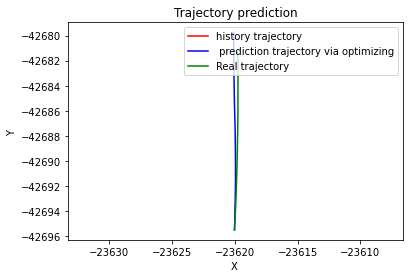

Test loss: 0.0166122437352746
MSE pre: 15.92727236411763
MSE RST: 0.6577071493002628
ADE_rst: 1.0619251278969224
FDE_rst: 1.5335550856934805
ADE_pre: 5.025329339819892
FDE_pre: 1.6499806430626358


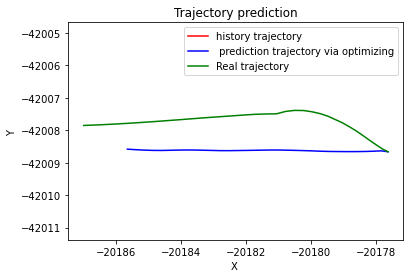

Test loss: 0.008465363529470861
MSE pre: 32.22240664468386
MSE RST: 0.3507004757231302
ADE_rst: 0.7361966389407473
FDE_rst: 1.105406229732999
ADE_pre: 7.4790400080006965
FDE_pre: 1.6619291626562909


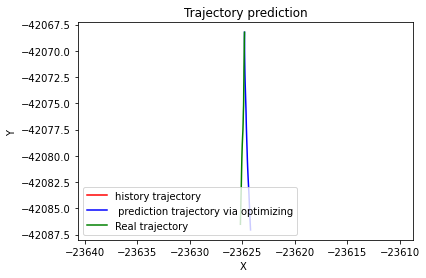

Test loss: 0.007054992457703368
MSE pre: 13.280390864866005
MSE RST: 0.2970585214503513
ADE_rst: 0.7184127271701959
FDE_rst: 0.9662572279990861
ADE_pre: 4.9081657704710855
FDE_pre: 1.6141006037908352


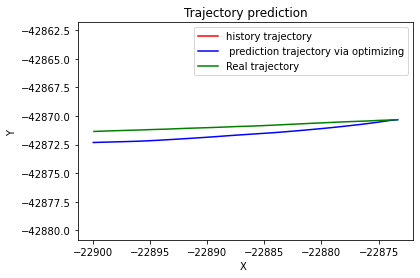

Test loss: 0.006333805403783321
MSE pre: 31.302606529354104
MSE RST: 1.0673951885138107
ADE_rst: 1.1636927163547028
FDE_rst: 2.8149104972154446
ADE_pre: 7.476685174386289
FDE_pre: 5.126116797774781


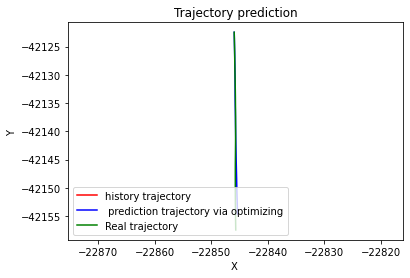

Test loss: 0.007691572490476033
MSE pre: 73.88303647686965
MSE RST: 1.0413973505822753
ADE_rst: 1.3446093198595093
FDE_rst: 0.8502651456287906
ADE_pre: 11.493993370343958
FDE_pre: 7.508007328622167


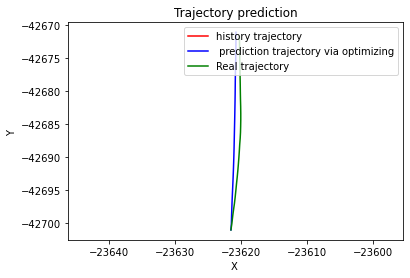

Test loss: 0.008529335771632552
MSE pre: 355.9803186311246
MSE RST: 3.4789684155524543
ADE_rst: 2.061823542773638
FDE_rst: 5.32775756212561
ADE_pre: 25.789093560763654
FDE_pre: 18.186055604177696


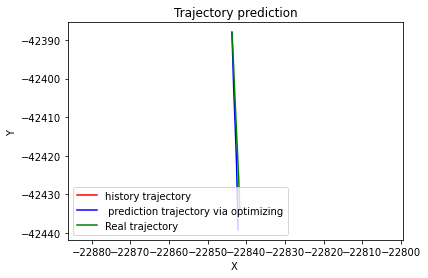

Test loss: 0.00809890698830406
MSE pre: 23.990055076573668
MSE RST: 1.0861842368080497
ADE_rst: 1.0334195013559322
FDE_rst: 3.5892795085980587
ADE_pre: 6.813687496196972
FDE_pre: 5.857403402623365


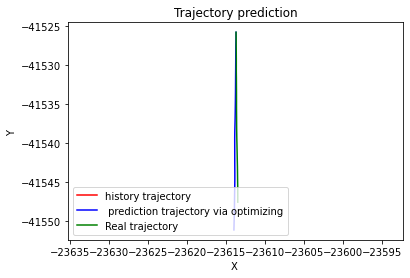

Test loss: 0.007830223948252342
MSE pre: 39.52990024642875
MSE RST: 0.07286170469143631
ADE_rst: 0.2815504377273028
FDE_rst: 0.9905719896294589
ADE_pre: 8.519824402134635
FDE_pre: 3.1488429633734807


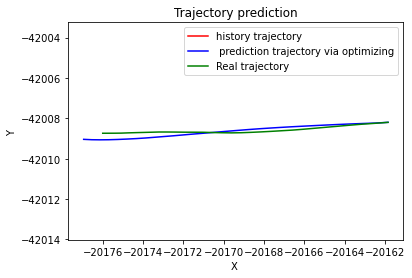

Test loss: 0.010409484947441715
MSE pre: 11.518032490943838
MSE RST: 0.2335733551796039
ADE_rst: 0.5521417863596467
FDE_rst: 1.3577937616447247
ADE_pre: 4.433710573461853
FDE_pre: 6.147989527099144


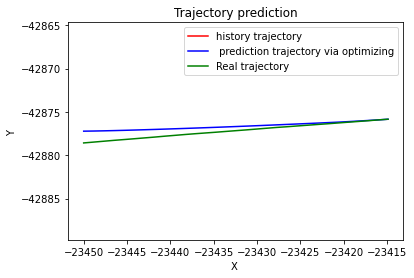

Test loss: 0.007914157077635516
MSE pre: 19.59247772949069
MSE RST: 0.6070977054306341
ADE_rst: 0.9572976743449844
FDE_rst: 1.7806905415567755
ADE_pre: 6.048410784698761
FDE_pre: 3.5458694552608248


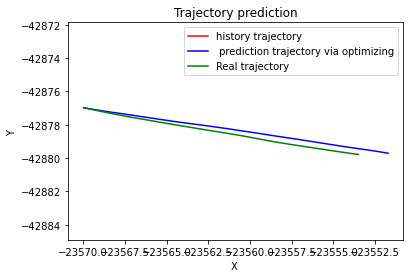

Test loss: 0.0066130119654382044
MSE pre: 3.389535205987789
MSE RST: 0.036482002509226494
ADE_rst: 0.22264470118010707
FDE_rst: 0.6068953983890152
ADE_pre: 2.284939134947732
FDE_pre: 5.794044284032152


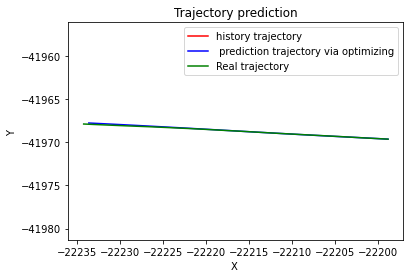

Test loss: 0.008512334471871367
MSE pre: 10.923353892395001
MSE RST: 0.18930280131459162
ADE_rst: 0.5204637989896074
FDE_rst: 0.9188081095780386
ADE_pre: 4.512866084691411
FDE_pre: 4.950982179871313


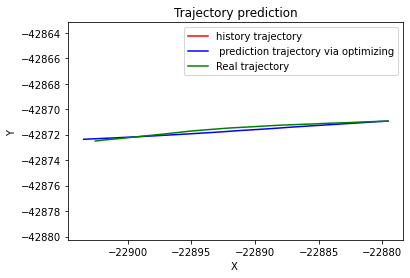

Test loss: 0.0076703493622719224
MSE pre: 40.12185507288562
MSE RST: 0.7572166538063303
ADE_rst: 0.941541646328921
FDE_rst: 2.3425911817220517
ADE_pre: 8.678205708080345
FDE_pre: 6.289116574352237


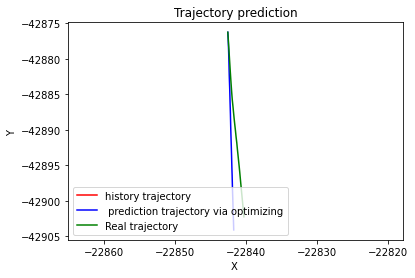

Test loss: 0.013566726898245805
MSE pre: 20.44131738167581
MSE RST: 0.5341098883094269
ADE_rst: 0.8813679228287414
FDE_rst: 1.8403490021014641
ADE_pre: 5.452950130206926
FDE_pre: 16.215619265735672


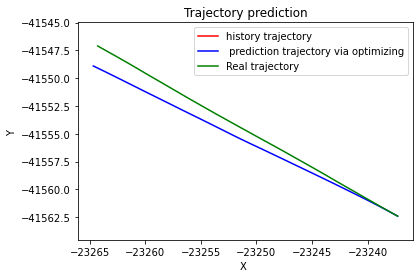

Test loss: 0.007958638854096858
MSE pre: 10.30732537993946
MSE RST: 0.013269957616844354
ADE_rst: 0.15193516369170793
FDE_rst: 0.21148381168597072
ADE_pre: 4.0302473869001645
FDE_pre: 1.7137135511691772


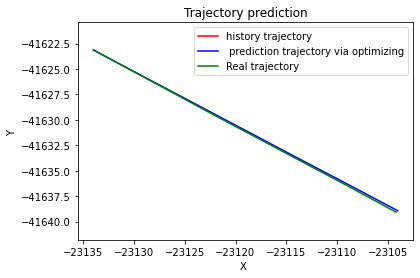

Test loss: 0.008640028905987298
MSE pre: 16.341098240809195
MSE RST: 1.5494467044168814
ADE_rst: 1.3448626891216688
FDE_rst: 3.432063930263665
ADE_pre: 5.419597464818403
FDE_pre: 8.621255754863764


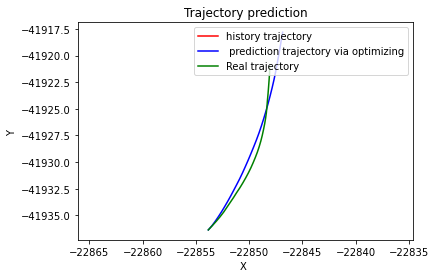

Test loss: 0.01190624049347752
MSE pre: 82.21490275406393
MSE RST: 0.05214980124105356
ADE_rst: 0.20528010394752783
FDE_rst: 0.9325048058722951
ADE_pre: 12.397928879741436
FDE_pre: 11.26156022340529


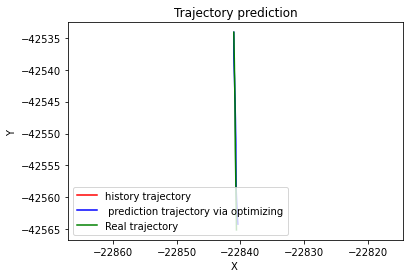

Test loss: 0.013409443787047491
MSE pre: 2.1812408688456566
MSE RST: 0.9825326226027323
ADE_rst: 1.071304798936132
FDE_rst: 2.974116473579054
ADE_pre: 1.902344106290824
FDE_pre: 4.097869637737195


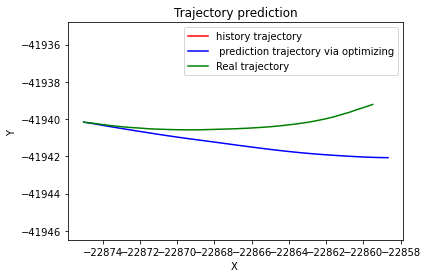

Test loss: 0.008034435325335668
MSE pre: 23.807652024312144
MSE RST: 0.2355295344343106
ADE_rst: 0.6093299892957834
FDE_rst: 0.7895331751313333
ADE_pre: 6.782608327788921
FDE_pre: 6.3008531992889205


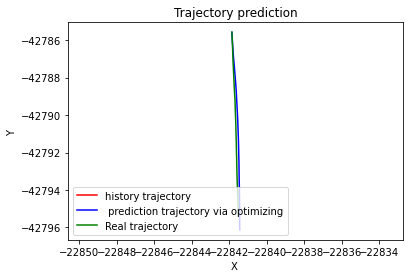

Test loss: 0.007346962412150949
MSE pre: 27.469956601178115
MSE RST: 0.10394636234694737
ADE_rst: 0.4221250412290397
FDE_rst: 0.4350304155868721
ADE_pre: 5.9076006519977895
FDE_pre: 10.269449847987488


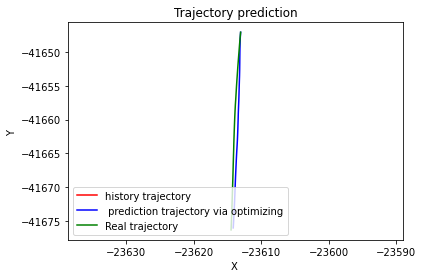

Test loss: 0.007430052190196311
MSE pre: 1.4346352425302116
MSE RST: 0.7985998390932835
ADE_rst: 1.0860692817889215
FDE_rst: 2.0618986925962743
ADE_pre: 1.5928088707824222
FDE_pre: 1.5596120946178569


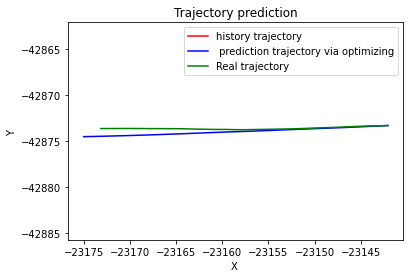

Test loss: 0.008140067523672096
MSE pre: 9.033548927213308
MSE RST: 0.5341708737306144
ADE_rst: 0.8573760866325285
FDE_rst: 1.8646571626103559
ADE_pre: 3.966461290333096
FDE_pre: 5.98062902848085


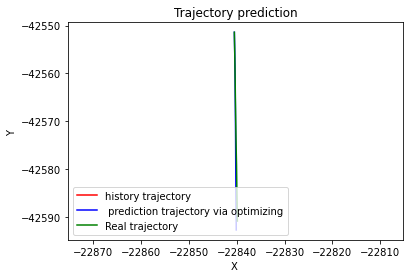

Test loss: 0.009915568746908684
MSE pre: 1.7174262712017399
MSE RST: 0.2413502430700193
ADE_rst: 0.5216113047406331
FDE_rst: 1.4562313698260072
ADE_pre: 1.5564857625732123
FDE_pre: 5.196971106838536


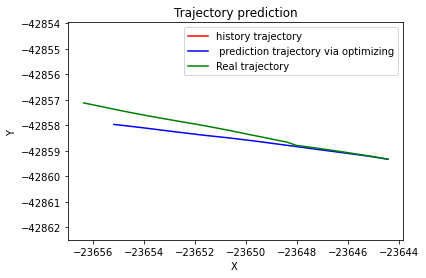

Test loss: 0.007581776879839457
MSE pre: 17.909153929380672
MSE RST: 0.5614698275383484
ADE_rst: 0.9033924122858801
FDE_rst: 1.7150668236252804
ADE_pre: 5.776724548025989
FDE_pre: 2.336481399526251


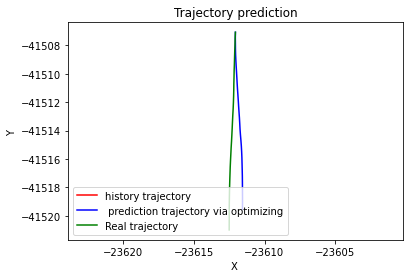

Test loss: 0.0069883890476097115
MSE pre: 226.14720584417472
MSE RST: 2.7081522564742433
ADE_rst: 2.1730221828838094
FDE_rst: 3.2416322516446536
ADE_pre: 20.304081719630663
FDE_pre: 7.758259303420092


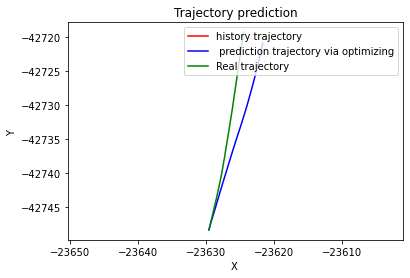

Test loss: 0.008831708874042492
MSE pre: 30.246199715587114
MSE RST: 4.402154170435993
ADE_rst: 2.355664494704938
FDE_rst: 4.404418830878615
ADE_pre: 7.334767825778601
FDE_pre: 10.37475615424834


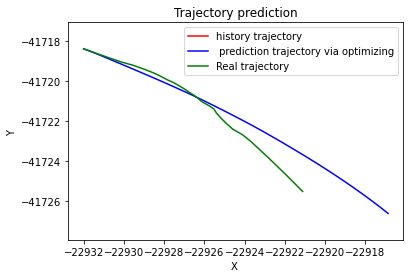

Test loss: 0.014350596645723879
MSE pre: 2.1071671217072825
MSE RST: 0.09477604028128453
ADE_rst: 0.3990774145434183
FDE_rst: 0.6880399018854658
ADE_pre: 1.8612277550166305
FDE_pre: 4.351123832972355


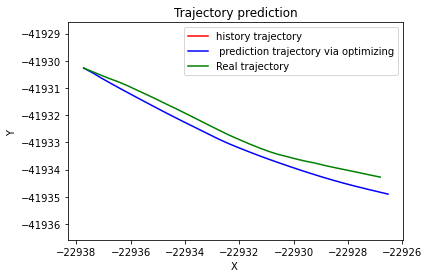

Test loss: 0.008592726893940503
MSE pre: 28.976108112614273
MSE RST: 0.27326799582554306
ADE_rst: 0.6222782782059605
FDE_rst: 1.3527869608445753
ADE_pre: 6.940197340868777
FDE_pre: 10.946202104421507


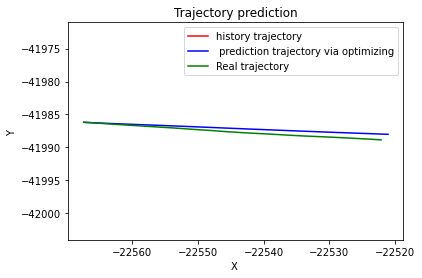

Test loss: 0.010640362204167078
MSE pre: 13.586899906232077
MSE RST: 3.6916727543873145
ADE_rst: 2.215554361981658
FDE_rst: 3.983096965434955
ADE_pre: 4.68844819523185
FDE_pre: 9.330441594199224


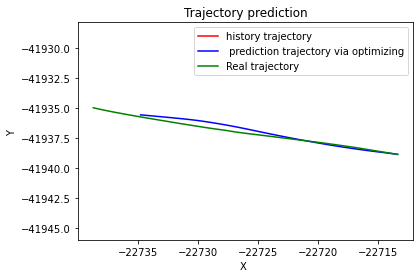

Test loss: 0.0071966969520610505
MSE pre: 5.76615674211153
MSE RST: 1.6117735188757518
ADE_rst: 1.436170361257294
FDE_rst: 3.2313369192359525
ADE_pre: 2.9988516020374485
FDE_pre: 9.88974532802048


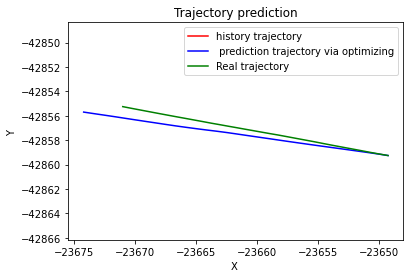

Test loss: 0.008095452904665434
MSE pre: 8.935929453224436
MSE RST: 1.8485726695282838
ADE_rst: 1.5763137078922118
FDE_rst: 3.6233156355278417
ADE_pre: 3.6346086810441216
FDE_pre: 9.569307747886096


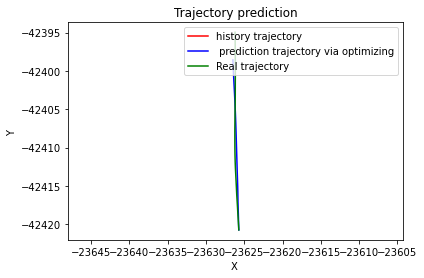

Test loss: 0.009006661741448244
MSE pre: 17.5672313452108
MSE RST: 0.5562250481688815
ADE_rst: 0.981088539289213
FDE_rst: 1.2400879191266982
ADE_pre: 5.559119394776735
FDE_pre: 5.308247614685409


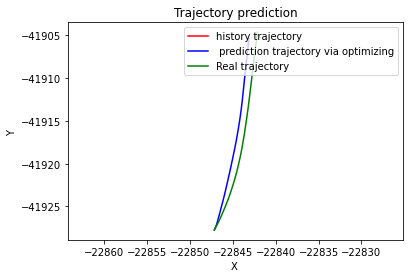

Test loss: 0.00807884051475603
MSE pre: 9.165429450051523
MSE RST: 0.011539221667969932
ADE_rst: 0.14149059588688342
FDE_rst: 0.18366791985056874
ADE_pre: 4.08385577390111
FDE_pre: 4.4117669698396185


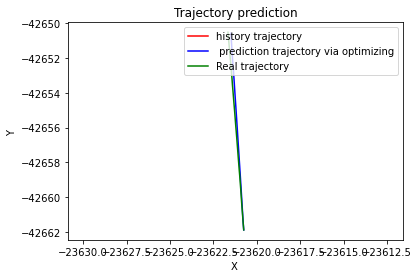

Test loss: 0.009119060970144009
MSE pre: 29.70648187495561
MSE RST: 0.8161721457793971
ADE_rst: 1.1182147282414456
FDE_rst: 2.296704747064597
ADE_pre: 6.965825928110858
FDE_pre: 7.242593398271847


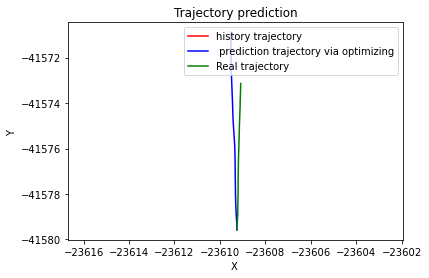

Test loss: 0.008496943449467055
MSE pre: 107.73251508730057
MSE RST: 4.582886348578474
ADE_rst: 2.609304251183811
FDE_rst: 4.9987560679350755
ADE_pre: 14.388351218085452
FDE_pre: 13.013665794595354


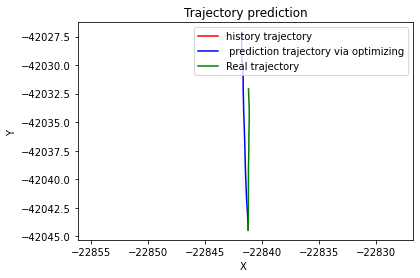

Test loss: 0.013616202852301947
MSE pre: 8.66026186817907
MSE RST: 0.11832097856784492
ADE_rst: 0.46474697275485993
FDE_rst: 0.5637038399844853
ADE_pre: 4.090931042489427
FDE_pre: 2.5299032724898294


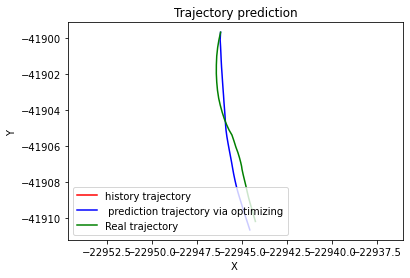

Test loss: 0.006762175335182109
MSE pre: 14.238963328623326
MSE RST: 0.4052007038590852
ADE_rst: 0.7793356776965659
FDE_rst: 1.3956661024478465
ADE_pre: 4.971859515471134
FDE_pre: 7.869061353120095


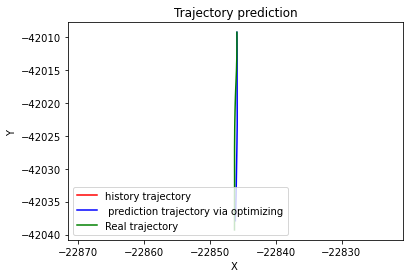

Test loss: 0.013694410304109433
MSE pre: 73.06146230271139
MSE RST: 0.6489502598593309
ADE_rst: 0.9489806112588371
FDE_rst: 1.9883314428172485
ADE_pre: 11.359674665928473
FDE_pre: 3.3103550421708157


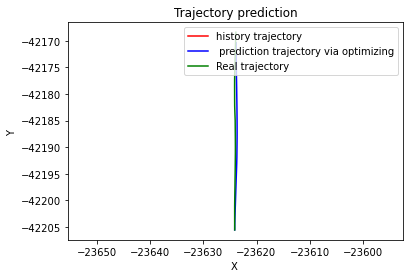

Test loss: 0.008595638957107361
MSE pre: 29.429962341789125
MSE RST: 0.446304885293152
ADE_rst: 0.8020288555446736
FDE_rst: 2.0338627720397677
ADE_pre: 7.100976910858277
FDE_pre: 3.2030138557445667


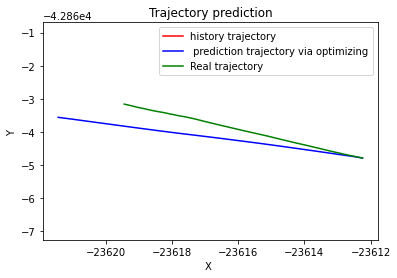

Test loss: 0.006120568070480426
MSE pre: 164.67375172310875
MSE RST: 0.3694577207951621
ADE_rst: 0.7529169567571967
FDE_rst: 1.3159493923696608
ADE_pre: 16.794943772539465
FDE_pre: 37.80086142076554


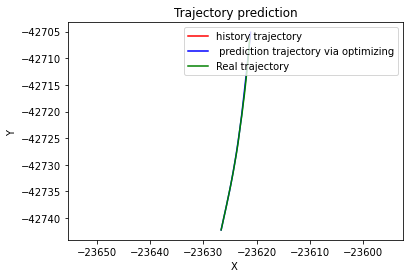

Test loss: 0.007498746553032597
MSE pre: 6.972194229505915
MSE RST: 1.089142943123984
ADE_rst: 0.9960982809589755
FDE_rst: 3.6270896886182973
ADE_pre: 3.3915684033057483
FDE_pre: 5.417351485725657


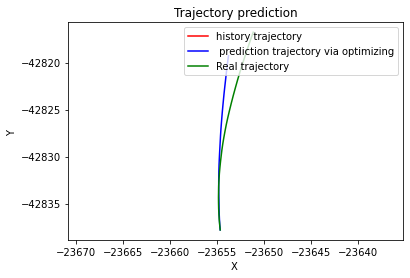

Test loss: 0.009224007376189763
MSE pre: 8.778487232465354
MSE RST: 0.20032751450440525
ADE_rst: 0.5339961948145736
FDE_rst: 1.1578318354809518
ADE_pre: 3.864206943033445
FDE_pre: 3.6191843564271413


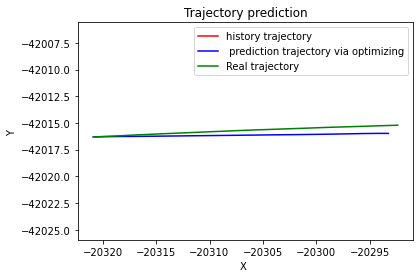

Test loss: 0.006774714059497955
MSE pre: 50.71122362950171
MSE RST: 0.1418923792616642
ADE_rst: 0.4616533560299559
FDE_rst: 0.2904569830516013
ADE_pre: 9.62928934452375
FDE_pre: 17.414343628378862


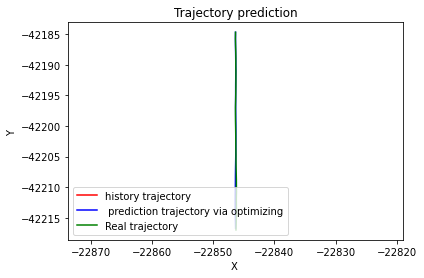

Test loss: 0.00799286257420038
MSE pre: 11.469039326126602
MSE RST: 0.2711899652144981
ADE_rst: 0.6019166195095018
FDE_rst: 1.3495768153773142
ADE_pre: 4.0925540881082245
FDE_pre: 11.996127594338587


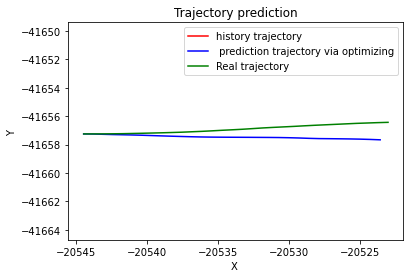

Test loss: 0.008046226508353455
MSE pre: 25.099524870090487
MSE RST: 0.12972732966391948
ADE_rst: 0.4397416258811373
FDE_rst: 0.853070142188787
ADE_pre: 6.1637212884031145
FDE_pre: 6.98257773954056


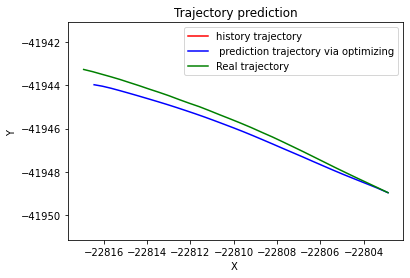

Test loss: 0.008622906904391823
MSE pre: 21.857082053718614
MSE RST: 0.07357043010227661
ADE_rst: 0.3596463205588291
FDE_rst: 0.4014792872760335
ADE_pre: 5.65189484846523
FDE_pre: 11.938849388975827


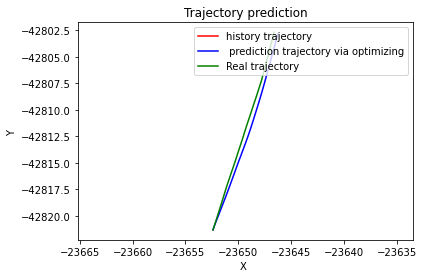

Test loss: 0.00616290178684486
MSE pre: 44.878541994206714
MSE RST: 0.37846400005390507
ADE_rst: 0.7684413324070654
FDE_rst: 1.290790915914293
ADE_pre: 9.263992167148935
FDE_pre: 9.53349620786852


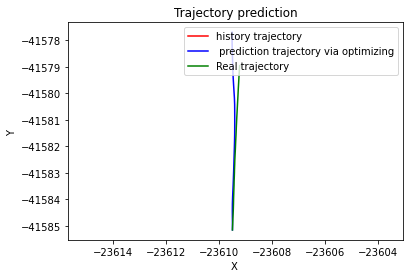

Test loss: 0.006674246327869794
MSE pre: 90.74394604643295
MSE RST: 0.533583936626071
ADE_rst: 0.7814675422203675
FDE_rst: 2.959998585948761
ADE_pre: 12.92029186294184
FDE_pre: 21.100407450733968


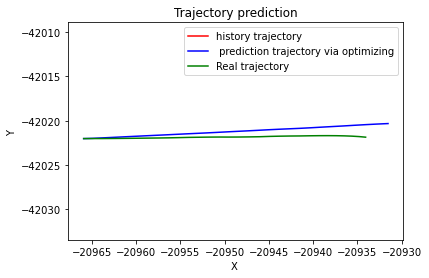

Test loss: 0.00826876503103018
MSE pre: 38.37304224569402
MSE RST: 0.6051335899624531
ADE_rst: 0.7828773005496207
FDE_rst: 2.373487029650416
ADE_pre: 8.504621288203749
FDE_pre: 8.315734861105721


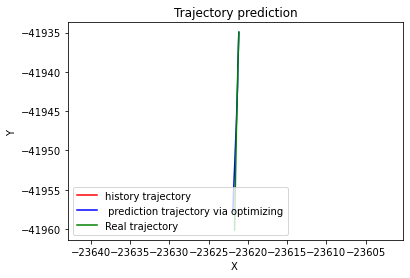

Test loss: 0.008491429117120001
MSE pre: 23.19364450521326
MSE RST: 0.33193962157149626
ADE_rst: 0.6730695280343069
FDE_rst: 1.5035458516762172
ADE_pre: 5.547026765631779
FDE_pre: 9.955235918184403


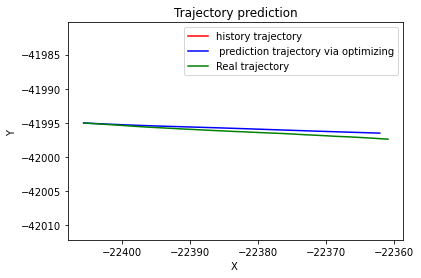

Test loss: 0.007667869318846868
MSE pre: 0.9307194793059947
MSE RST: 0.31410430660877053
ADE_rst: 0.6790821218387106
FDE_rst: 1.5906338761470815
ADE_pre: 1.1526494364738311
FDE_pre: 3.500907586213022


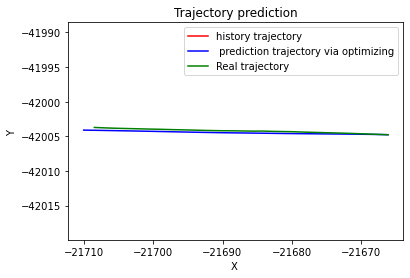

Test loss: 0.0075621252101417
MSE pre: 32.35896324420888
MSE RST: 0.394223466929131
ADE_rst: 0.7335620281768425
FDE_rst: 1.2924206978094832
ADE_pre: 6.243064385821891
FDE_pre: 17.499849669308222


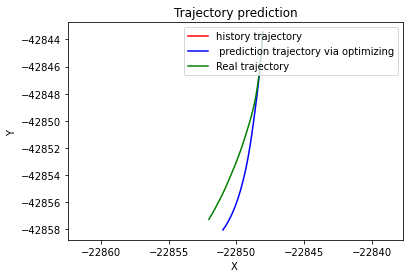

Test loss: 0.00793885759746966
MSE pre: 2.8940939890766657
MSE RST: 0.11679997503918357
ADE_rst: 0.4286247929498262
FDE_rst: 0.5172921860128762
ADE_pre: 2.1948611925659796
FDE_pre: 3.2671092352970006


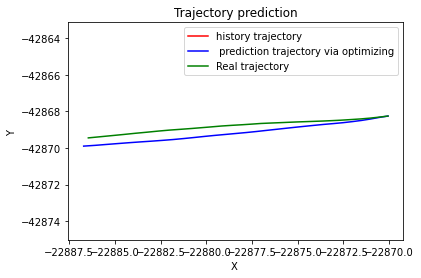

Test loss: 0.008901264532431572
MSE pre: 43.77983518110655
MSE RST: 0.19337454812531535
ADE_rst: 0.5336641081160698
FDE_rst: 1.1406533577264029
ADE_pre: 8.316113206998597
FDE_pre: 7.680460457291789


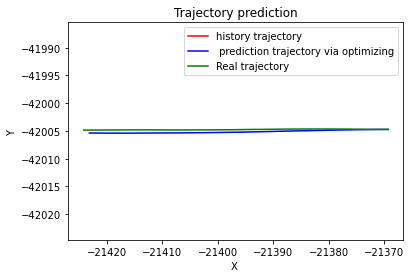

Test loss: 0.0064710800706499014
MSE pre: 28.324270192593985
MSE RST: 0.13642993226148645
ADE_rst: 0.45500407543851307
FDE_rst: 0.8423444720866011
ADE_pre: 7.171692880168299
FDE_pre: 4.030420670767557


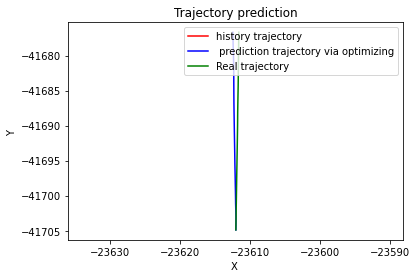

Test loss: 0.007509964727143748
MSE pre: 12.757560954239837
MSE RST: 0.8612719348598797
ADE_rst: 1.1057009858995988
FDE_rst: 2.2008396996465684
ADE_pre: 3.9946455794129774
FDE_pre: 12.538456027395355


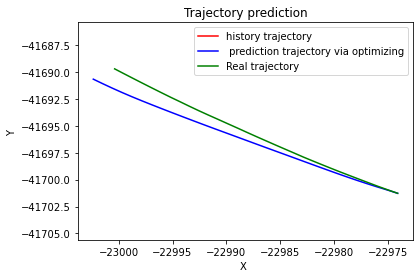

Test loss: 0.00832675497830476
MSE pre: 2.237345351258744
MSE RST: 0.08415260426029766
ADE_rst: 0.3288091564652788
FDE_rst: 0.7271418867608627
ADE_pre: 1.9705065864481686
FDE_pre: 1.575383272810359


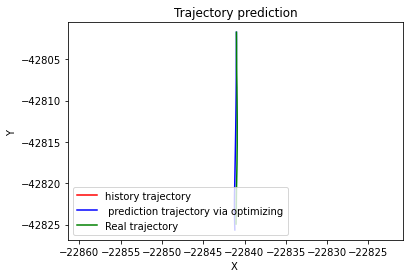

Test loss: 0.007685298123608842
MSE pre: 6.669992094940887
MSE RST: 0.24035253468265047
ADE_rst: 0.5306301193699371
FDE_rst: 2.047175612583444
ADE_pre: 3.383042135429461
FDE_pre: 3.4331906367608136


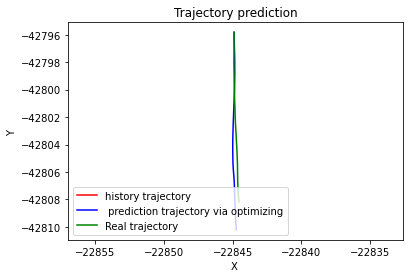

Test loss: 0.009085237556766676
MSE pre: 1.898547121565455
MSE RST: 0.5641436691995487
ADE_rst: 0.8963430062391552
FDE_rst: 2.079324275729872
ADE_pre: 1.7127238081528324
FDE_pre: 1.1837029390278389


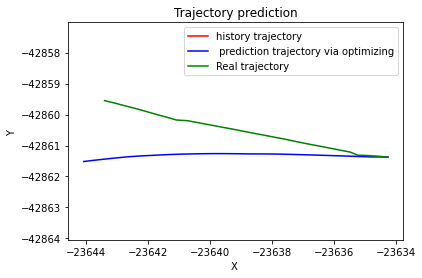

Test loss: 0.009580219603405599
MSE pre: 34.62403606138814
MSE RST: 0.30646900448781067
ADE_rst: 0.6537649980121744
FDE_rst: 1.468527837696339
ADE_pre: 8.167370086664285
FDE_pre: 9.735491273855281


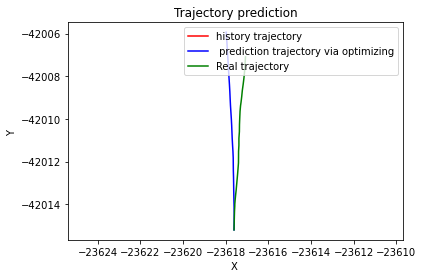

Test loss: 0.007735635178136824
MSE pre: 24.023229537880706
MSE RST: 0.45768669988406513
ADE_rst: 0.7935334469476959
FDE_rst: 1.5577899789236465
ADE_pre: 6.605838300998303
FDE_pre: 5.948157406708181


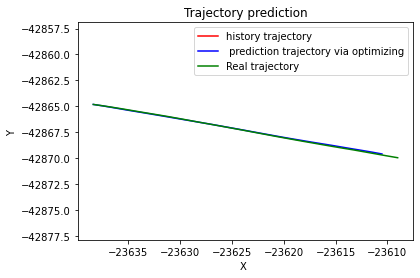

Test loss: 0.008186573081844391
MSE pre: 60.37959916260937
MSE RST: 0.7241006132185741
ADE_rst: 0.863435222978029
FDE_rst: 2.7578162604757086
ADE_pre: 9.71206996275594
FDE_pre: 5.535686823955114


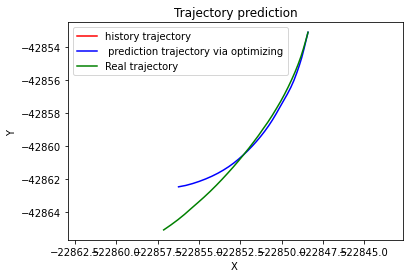

Test loss: 0.014298307162760213
MSE pre: 43.1805448828372
MSE RST: 2.7350513090329716
ADE_rst: 1.8460498456691936
FDE_rst: 4.818683261319587
ADE_pre: 9.068513596382086
FDE_pre: 8.578523717127146


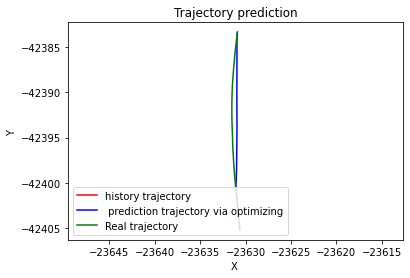

Test loss: 0.007744704589034331
MSE pre: 29.42087300501908
MSE RST: 0.17747928319358264
ADE_rst: 0.5150665752982794
FDE_rst: 0.99770767506074
ADE_pre: 7.259531125651654
FDE_pre: 2.7593315999042423


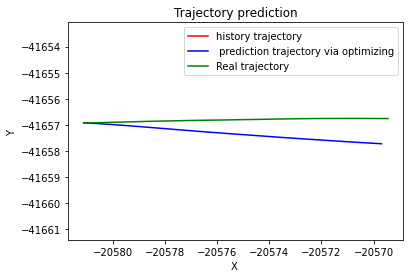

Test loss: 0.009107186919644999
MSE pre: 8.174087946116801
MSE RST: 2.4174795678270216
ADE_rst: 1.789053382955293
FDE_rst: 4.219042463865045
ADE_pre: 3.7315315810186482
FDE_pre: 0.8012335069449074


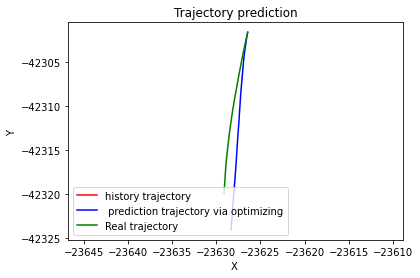

Test loss: 0.007622928768100351
MSE pre: 4.300226593624149
MSE RST: 1.531655283027368
ADE_rst: 1.4922607317387364
FDE_rst: 2.6391035448070665
ADE_pre: 2.7173372376105656
FDE_pre: 5.825295849592994


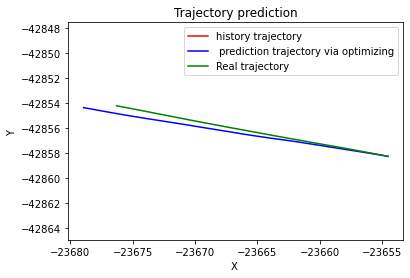

Test loss: 0.013263590735748404
MSE pre: 7.324815854959861
MSE RST: 0.07072293411991927
ADE_rst: 0.3210744785665221
FDE_rst: 0.7018236881087276
ADE_pre: 3.5488039097448127
FDE_pre: 2.2932483773864054


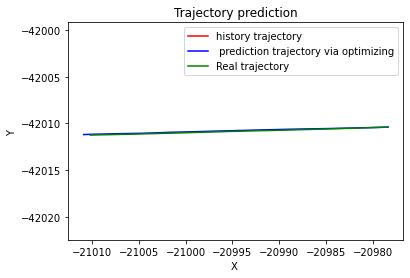

Test loss: 0.013695761828388376
MSE pre: 6.726873320978911
MSE RST: 0.2414709174764142
ADE_rst: 0.4778109624266739
FDE_rst: 1.486353479954751
ADE_pre: 3.6082594957359455
FDE_pre: 1.838174475199976


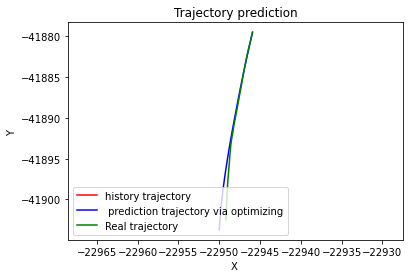

Test loss: 0.009901044561814842
MSE pre: 2.066140594692361
MSE RST: 1.0137268627196494
ADE_rst: 1.1655964951996114
FDE_rst: 2.562240898229143
ADE_pre: 1.79170569686195
FDE_pre: 1.8753103876700639


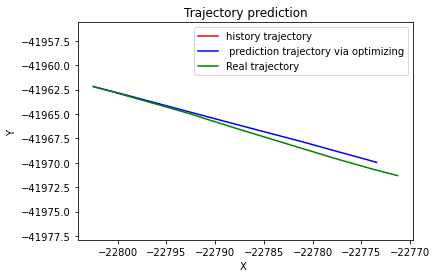

Test loss: 0.009856057997179172
MSE pre: 76.00157459262108
MSE RST: 1.9473500819067568
ADE_rst: 1.5968711089964502
FDE_rst: 3.604285995709344
ADE_pre: 11.665697091976355
FDE_pre: 7.062826243925423


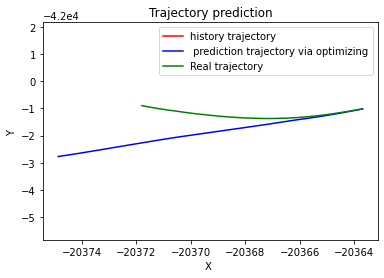

Test loss: 0.012825168515575419
MSE pre: 27.027668461810283
MSE RST: 0.14111075152771804
ADE_rst: 0.5015658045898045
FDE_rst: 0.4673436847362829
ADE_pre: 6.755934572764709
FDE_pre: 4.983741456369926


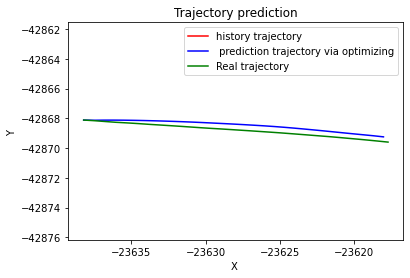

Test loss: 0.008148247283573495
MSE pre: 26.688975923727988
MSE RST: 0.54282614454421
ADE_rst: 0.8333226042618541
FDE_rst: 2.2378558835109983
ADE_pre: 7.099633582411583
FDE_pre: 7.486396949539123


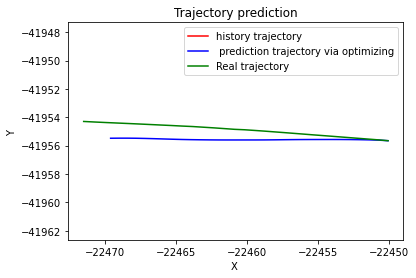

Test loss: 0.006662892899010081
MSE pre: 29.79131114732637
MSE RST: 0.11253252791954942
ADE_rst: 0.39509876666715293
FDE_rst: 0.8727968022574176
ADE_pre: 7.684784745500965
FDE_pre: 8.900344346694554


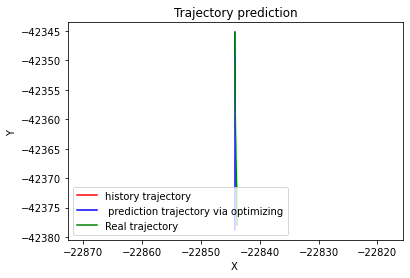

Test loss: 0.009656431853435498
MSE pre: 35.282680324824234
MSE RST: 0.5889410504869462
ADE_rst: 0.9103791593314555
FDE_rst: 1.9020886165649145
ADE_pre: 8.21978084186712
FDE_pre: 12.434352015634834


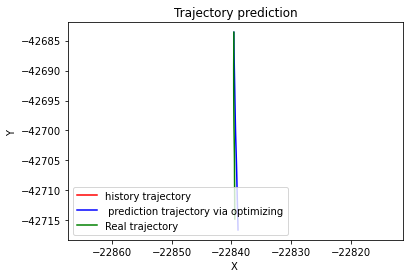

Test loss: 0.007735419797519078
MSE pre: 22.18267685586605
MSE RST: 2.376229519685709
ADE_rst: 1.6636934906585115
FDE_rst: 3.105781970132798
ADE_pre: 6.345206459076955
FDE_pre: 9.922147185922904


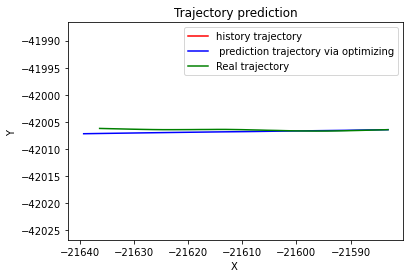

Test loss: 0.009509735252963234
MSE pre: 1.1068082105877848
MSE RST: 0.30694869183169027
ADE_rst: 0.6867528146570605
FDE_rst: 1.0382293077731086
ADE_pre: 1.3843132776556522
FDE_pre: 3.159914869035456


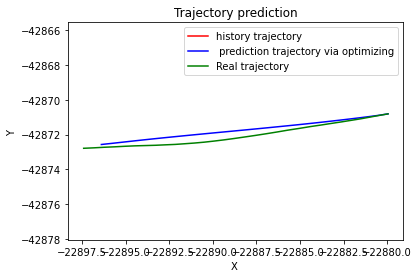

Test loss: 0.008448287618589784
MSE pre: 12.237905998075782
MSE RST: 0.14450434862452144
ADE_rst: 0.5016195698915485
FDE_rst: 0.8948033819629384
ADE_pre: 4.917955950375247
FDE_pre: 4.762518396797042


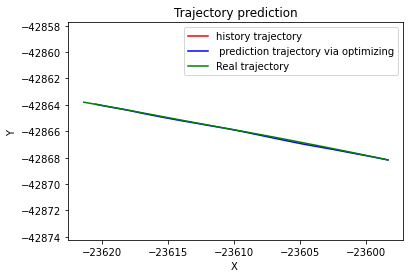

Test loss: 0.008450769662524076
MSE pre: 17.837416545079538
MSE RST: 1.4432470987861379
ADE_rst: 1.266562787268019
FDE_rst: 3.851180971390657
ADE_pre: 5.694493569863226
FDE_pre: 2.8531354062621266


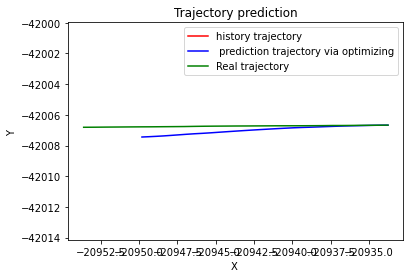

Test loss: 0.006243401647342106
MSE pre: 9.86436748060579
MSE RST: 0.22305356198971943
ADE_rst: 0.5936480538147842
FDE_rst: 1.0287639071318386
ADE_pre: 4.175462878208074
FDE_pre: 6.318437388627029


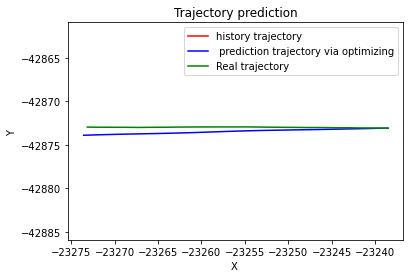

Test loss: 0.013525163664068808
MSE pre: 21.112717816875737
MSE RST: 0.4479514092247075
ADE_rst: 0.6447955007716261
FDE_rst: 2.394353464472304
ADE_pre: 6.345574977515711
FDE_pre: 3.590847475800445


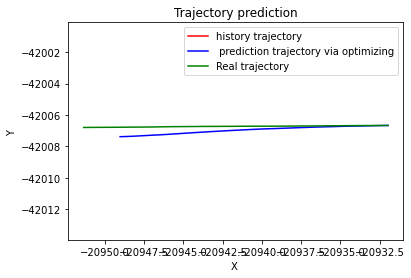

Test loss: 0.007621273398998923
MSE pre: 48.63591727308725
MSE RST: 0.29415395614091217
ADE_rst: 0.6317244094078484
FDE_rst: 1.7105164627148297
ADE_pre: 9.348760900785427
FDE_pre: 9.513444116265509


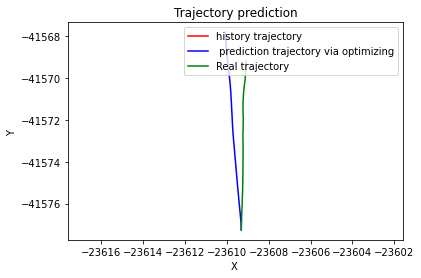

Test loss: 0.009124248682803838
MSE pre: 18.422000923259763
MSE RST: 4.994830299922096
ADE_rst: 2.3141105956545482
FDE_rst: 6.980309720187253
ADE_pre: 5.240102405794732
FDE_pre: 9.738488762419546


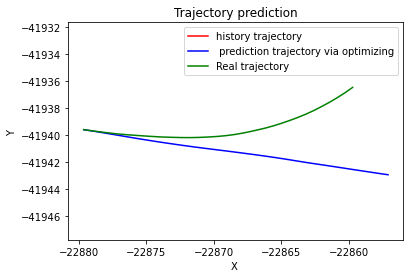

Test loss: 0.006477728815115259
MSE pre: 16.84275030512302
MSE RST: 0.18241943565949126
ADE_rst: 0.5201946989084784
FDE_rst: 0.8544426080061933
ADE_pre: 4.674690616518682
FDE_pre: 9.718563852043511


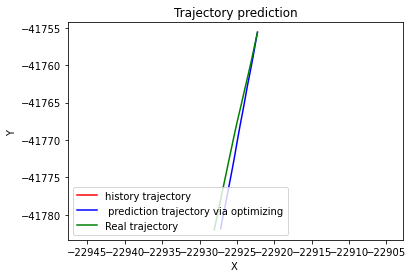

Test loss: 0.007644190195876223
MSE pre: 490.82591609389755
MSE RST: 0.6144949736745412
ADE_rst: 0.9225972562080473
FDE_rst: 2.542129858591101
ADE_pre: 30.091384736881487
FDE_pre: 31.774682856170834


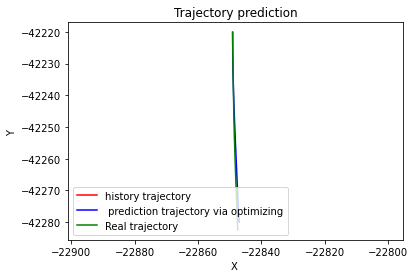

Test loss: 0.008811897311561605
MSE pre: 16.756698935851865
MSE RST: 0.5405672892330745
ADE_rst: 0.775303494565064
FDE_rst: 2.1972688695769733
ADE_pre: 5.400929241089462
FDE_pre: 1.1277872868559848


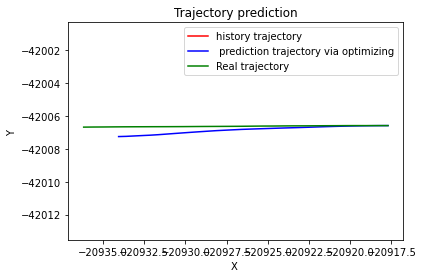

Test loss: 0.008580284207041666
MSE pre: 14.607992143455338
MSE RST: 0.35780562024955065
ADE_rst: 0.7102860053562041
FDE_rst: 0.6795300466785825
ADE_pre: 5.130354382071463
FDE_pre: 4.329869812474594


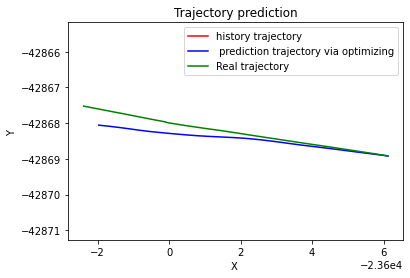

Test loss: 0.007784658618048186
MSE pre: 742.6730589430539
MSE RST: 2.8030714625212814
ADE_rst: 1.8554202231234915
FDE_rst: 4.8121876913727775
ADE_pre: 37.507022817919
FDE_pre: 33.018499589322005


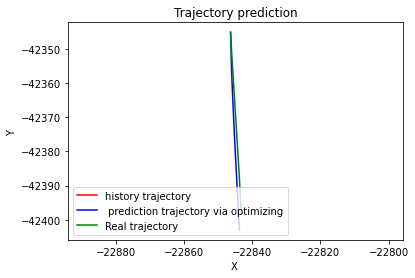

Test loss: 0.007084631232941384
MSE pre: 9.625877107844886
MSE RST: 0.19096502854033007
ADE_rst: 0.5609621468111996
FDE_rst: 0.8068062394722423
ADE_pre: 4.145152177992667
FDE_pre: 5.619524210645096


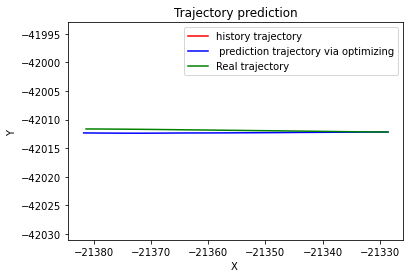

Test loss: 0.010033463245197816
MSE pre: 5.7806047073167
MSE RST: 1.0526830798819347
ADE_rst: 1.2391977147301814
FDE_rst: 2.6857877881170444
ADE_pre: 3.0581382535780284
FDE_pre: 8.149488318606139


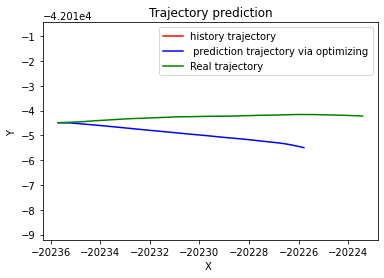

Test loss: 0.007735500264438909
MSE pre: 13.56098895446127
MSE RST: 0.6508013664699555
ADE_rst: 0.9746862344685812
FDE_rst: 2.741571249954371
ADE_pre: 4.82071819364281
FDE_pre: 8.177361494047721


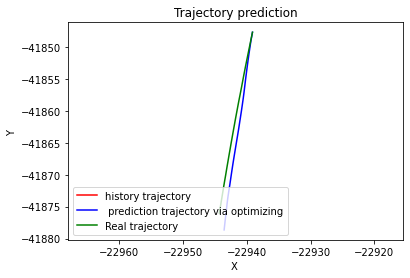

Test loss: 0.008134540530864261
MSE pre: 13.779600673972686
MSE RST: 0.2919880317952396
ADE_rst: 0.6657175874287417
FDE_rst: 1.2874048019605557
ADE_pre: 4.09556254533879
FDE_pre: 5.2673227997885474


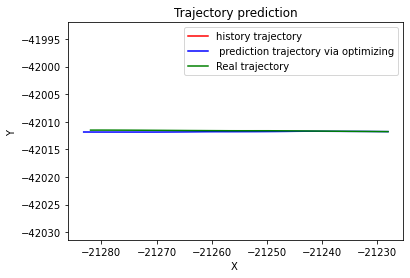

Test loss: 0.007234843288420044
MSE pre: 63.91869947473628
MSE RST: 0.03732775167178419
ADE_rst: 0.24042613089028406
FDE_rst: 0.47324501964546417
ADE_pre: 10.290520499679566
FDE_pre: 11.059906345961972


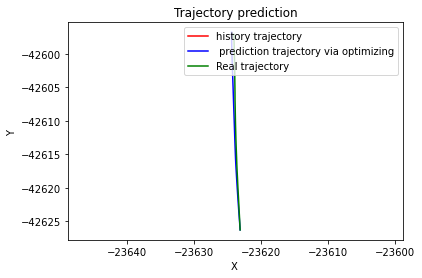

Test loss: 0.007208079701926468
MSE pre: 87.40367984890453
MSE RST: 6.812047185746705
ADE_rst: 3.055153886872571
FDE_rst: 6.682410093043992
ADE_pre: 12.004828388438638
FDE_pre: 9.402875229957703


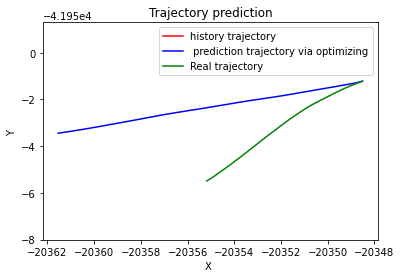

Test loss: 0.007939987122213376
MSE pre: 26.42307310346963
MSE RST: 0.7066897366360274
ADE_rst: 1.0133614016784258
FDE_rst: 1.767204169708536
ADE_pre: 7.1855625678337125
FDE_pre: 6.608097391467549


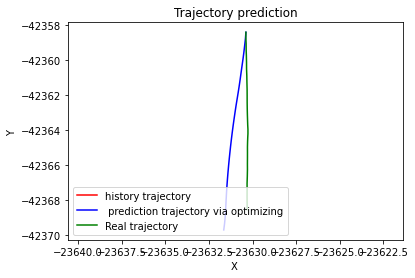

Test loss: 0.009032533131838315
MSE pre: 33.930563138887706
MSE RST: 1.5513662416840308
ADE_rst: 1.360372564383125
FDE_rst: 3.6369689680518036
ADE_pre: 8.021955483754898
FDE_pre: 6.505574742229291


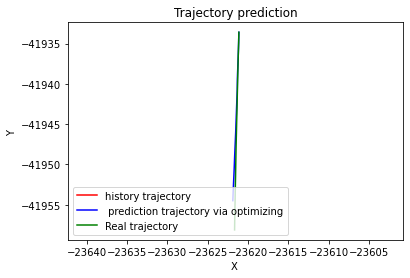

Test loss: 0.007945288497296579
MSE pre: 13.840801580446449
MSE RST: 0.20046044394402154
ADE_rst: 0.5345391339685954
FDE_rst: 1.1673588195854234
ADE_pre: 5.179395954755655
FDE_pre: 3.067751937120122


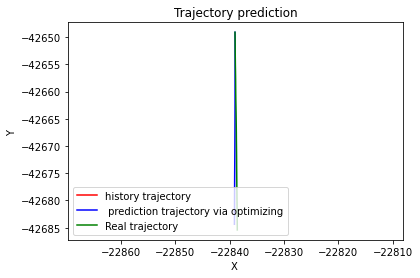

Test loss: 0.007890964167910344
MSE pre: 43.57034579764222
MSE RST: 0.3463026169835205
ADE_rst: 0.7357334464775481
FDE_rst: 1.191460133304927
ADE_pre: 8.925562091696527
FDE_pre: 7.562874010686601


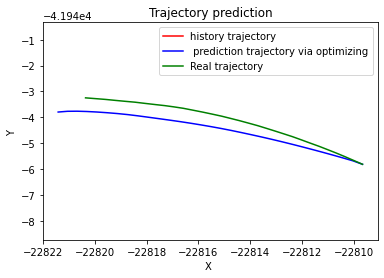

Test loss: 0.009061155909199748
MSE pre: 15.049771231248544
MSE RST: 2.4388428889650027
ADE_rst: 1.9041202432764428
FDE_rst: 3.6723412656768692
ADE_pre: 4.9354560610302505
FDE_pre: 3.5408172450328244


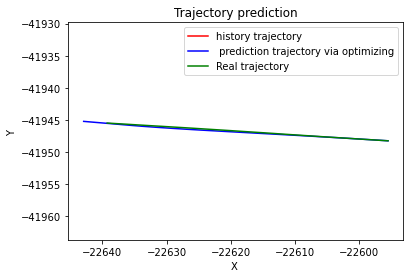

Test loss: 0.006741691624400958
MSE pre: 11.740965650550512
MSE RST: 1.082112493748546
ADE_rst: 1.2374888823355708
FDE_rst: 2.4719081143114305
ADE_pre: 4.688297940168746
FDE_pre: 5.973932335222975


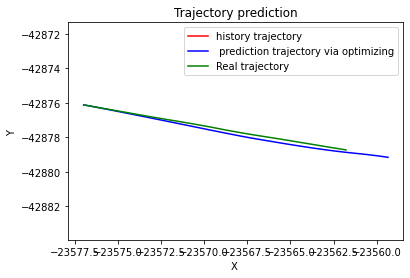

Test loss: 0.008605791013205277
MSE pre: 53.77366783680742
MSE RST: 0.8939193923713412
ADE_rst: 0.958411820662516
FDE_rst: 3.286990158709963
ADE_pre: 9.840025304087021
FDE_pre: 4.343055418334056


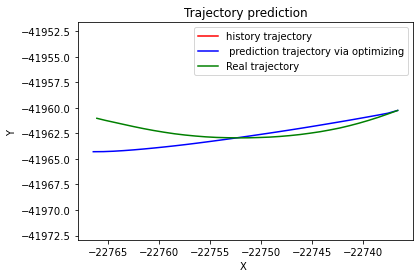

Test loss: 0.00802741662373468
MSE pre: 7.309955668988253
MSE RST: 0.021061836744756104
ADE_rst: 0.19076994946108633
FDE_rst: 0.320949552053839
ADE_pre: 3.655767666336751
FDE_pre: 2.707707668334337


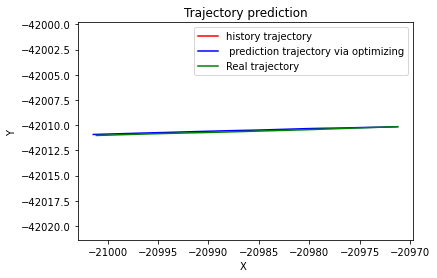

Test loss: 0.01616567387750608
MSE pre: 9.640717611289022
MSE RST: 0.19449473089973282
ADE_rst: 0.4972264883925938
FDE_rst: 1.199119749407206
ADE_pre: 4.0596903405938
FDE_pre: 7.083639467759435


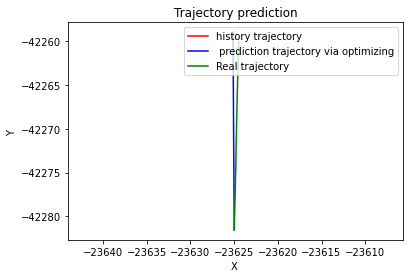

Test loss: 0.007921681728160698
MSE pre: 112.66361527869132
MSE RST: 5.973652339472372
ADE_rst: 2.98214679948005
FDE_rst: 3.0518182054333947
ADE_pre: 14.567895896638456
FDE_pre: 5.232734207760586


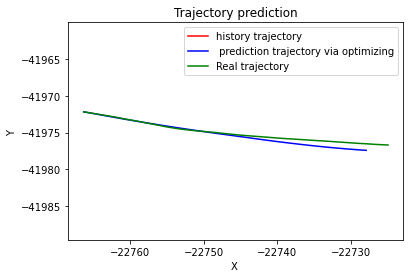

Test loss: 0.0088832811585331
MSE pre: 71.96818605764025
MSE RST: 0.018203510992347974
ADE_rst: 0.17462558120871388
FDE_rst: 0.29985379961708664
ADE_pre: 11.419258047237795
FDE_pre: 9.568450864146525


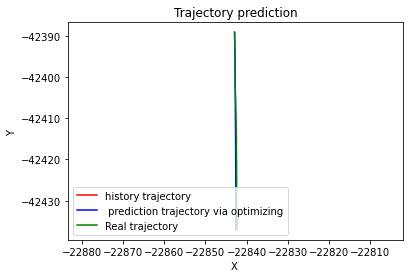

Test loss: 0.010806220723388181
MSE pre: 77.97802023575444
MSE RST: 0.13696360628193732
ADE_rst: 0.46623953660464396
FDE_rst: 0.6281432393659793
ADE_pre: 12.211695147661741
FDE_pre: 14.651380810439978


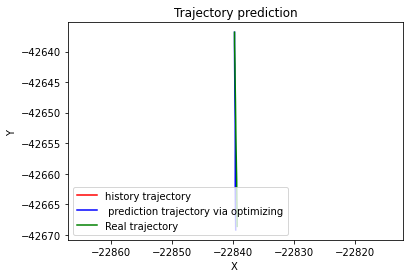

Test loss: 0.00975143564332895
MSE pre: 26.548987084951857
MSE RST: 7.597245655920774
ADE_rst: 2.9248735589349915
FDE_rst: 6.611238939230163
ADE_pre: 6.804455482913372
FDE_pre: 11.625275947879006


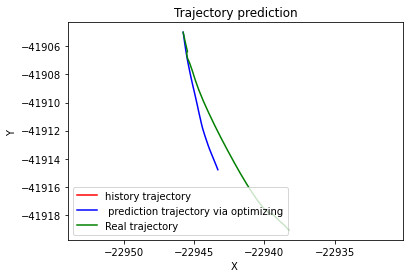

Test loss: 0.010679991842376493
MSE pre: 5.07998958084292
MSE RST: 0.542296209833792
ADE_rst: 0.7463950344675978
FDE_rst: 2.2294138486957307
ADE_pre: 2.7139985733360437
FDE_pre: 3.880726926726045


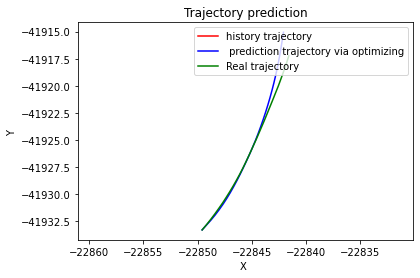

Test loss: 0.012213486424740756
MSE pre: 14.303643008877694
MSE RST: 0.04571531122948822
ADE_rst: 0.2836022277803326
FDE_rst: 0.2891450495785602
ADE_pre: 5.047869440779078
FDE_pre: 3.4740257524264186


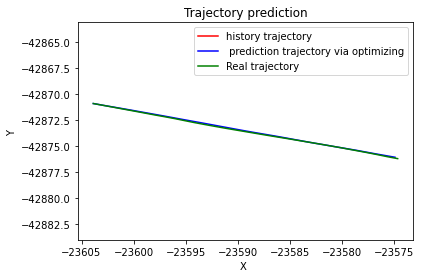

Test loss: 0.00834140845050368
MSE pre: 10.148264853464612
MSE RST: 0.5720573928528572
ADE_rst: 0.920231388598053
FDE_rst: 1.4378402271724917
ADE_pre: 4.257560846674845
FDE_pre: 7.336255349277813


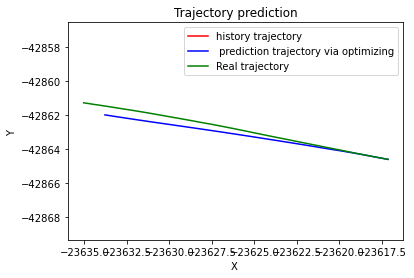

Test loss: 0.007698531978982944
MSE pre: 7.8105469976606825
MSE RST: 0.3482713762988256
ADE_rst: 0.735517047883229
FDE_rst: 1.3987046231899003
ADE_pre: 3.5140203658584306
FDE_pre: 4.738415606330177


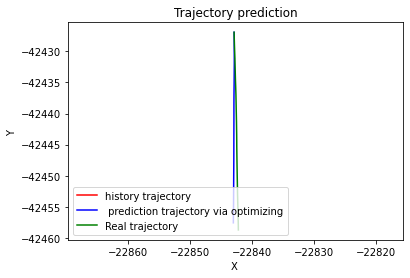

Test loss: 0.007262266111151561
MSE pre: 3.134985807648302
MSE RST: 0.3712951943577479
ADE_rst: 0.8050073308453725
FDE_rst: 1.0717245636023731
ADE_pre: 2.3381686422063086
FDE_pre: 2.8705479400015745


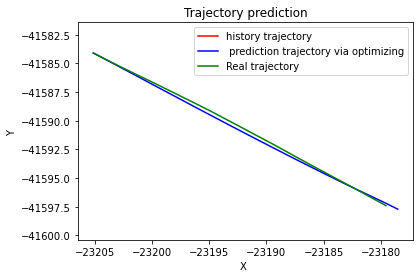

Test loss: 0.008181980170413695
MSE pre: 5.076781050496295
MSE RST: 0.09042774509655002
ADE_rst: 0.34362181477035825
FDE_rst: 0.8206301854081143
ADE_pre: 3.087725707902271
FDE_pre: 3.2401300374111552


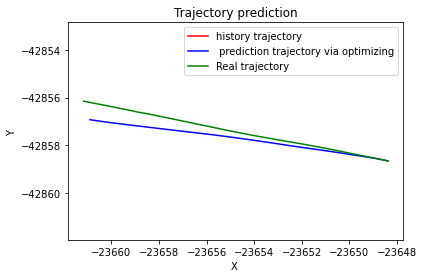

Test loss: 0.007126506525020534
MSE pre: 15.397327145338103
MSE RST: 0.19700697445148638
ADE_rst: 0.4548070870397806
FDE_rst: 1.5979135700977567
ADE_pre: 4.513460646400079
FDE_pre: 5.7416877838101765


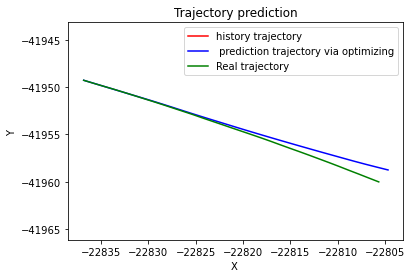

Test loss: 0.008129907232825912
MSE pre: 10.457001990194842
MSE RST: 0.7038693950652148
ADE_rst: 0.9360490891438308
FDE_rst: 2.248199429646055
ADE_pre: 4.398309631567044
FDE_pre: 4.420257651948317


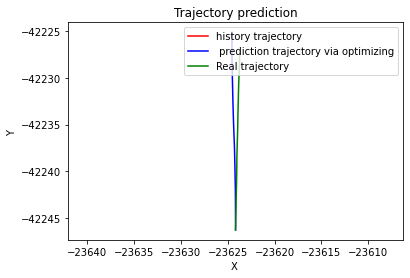

Test loss: 0.01321053315362594
MSE pre: 37.03633630805871
MSE RST: 11.137631470466276
ADE_rst: 3.7726216795948617
FDE_rst: 7.563693133034239
ADE_pre: 7.9659729800578924
FDE_pre: 13.113103194373842


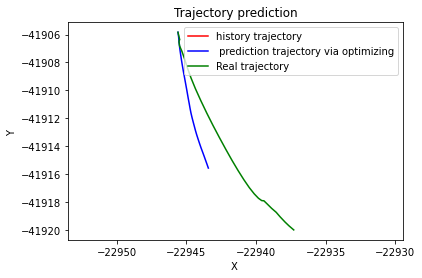

Test loss: 0.008262708476732009
MSE pre: 30.73479567487763
MSE RST: 0.11571053580340705
ADE_rst: 0.4086026605882349
FDE_rst: 0.7255671567717173
ADE_pre: 7.570751393946201
FDE_pre: 11.315345968367707


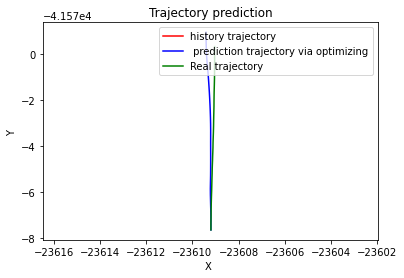

Test loss: 0.007685193212127907
MSE pre: 10.853248461737458
MSE RST: 1.2469081439366265
ADE_rst: 1.3096995733467662
FDE_rst: 2.9446739804677464
ADE_pre: 4.365592652433086
FDE_pre: 7.192920832920479


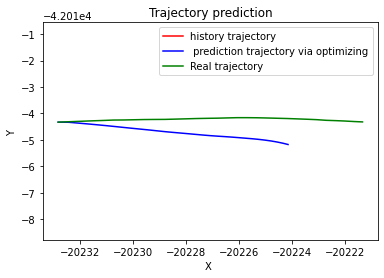

Test loss: 0.014342734545908975
MSE pre: 71.29588656979169
MSE RST: 0.5392391325729666
ADE_rst: 0.9369489565389639
FDE_rst: 1.3681297852346508
ADE_pre: 10.05211685514341
FDE_pre: 6.110846005183672


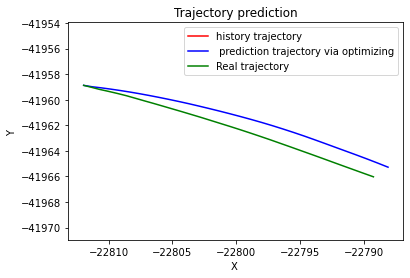

Test loss: 0.00752781021305049
MSE pre: 69.28927409433904
MSE RST: 0.2634759835349032
ADE_rst: 0.5627593475987774
FDE_rst: 1.40441400641362
ADE_pre: 11.422646706195822
FDE_pre: 17.14260300581235


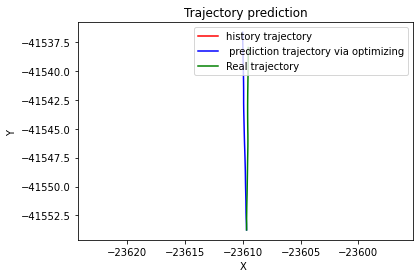

Test loss: 0.007380858511491827
MSE pre: 10.679316910409034
MSE RST: 0.10948239433201969
ADE_rst: 0.4090144499807122
FDE_rst: 0.5100648880968629
ADE_pre: 4.25452956016569
FDE_pre: 8.298447161098808


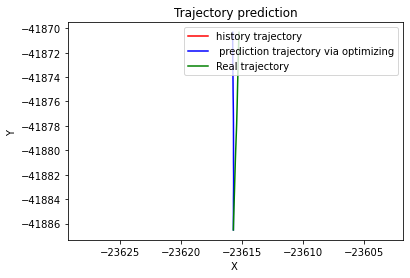

Test loss: 0.013193475177403791
MSE pre: 5.643516139658839
MSE RST: 1.771996505561236
ADE_rst: 1.5519953289495532
FDE_rst: 3.389075094356401
ADE_pre: 2.990754461833237
FDE_pre: 5.793330612861145


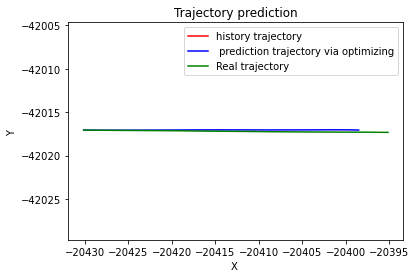

Test loss: 0.006310361420841228
MSE pre: 15.005322644177976
MSE RST: 0.09802033865354205
ADE_rst: 0.3583769558834468
FDE_rst: 0.8992591318195939
ADE_pre: 4.875444922925994
FDE_pre: 11.60687706320592


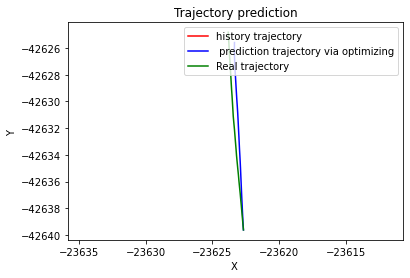

Test loss: 0.009006180202278943
MSE pre: 63.90057017559052
MSE RST: 3.6748055009190748
ADE_rst: 2.143553067696131
FDE_rst: 5.0856058255142
ADE_pre: 11.032708417985296
FDE_pre: 8.862911489422293


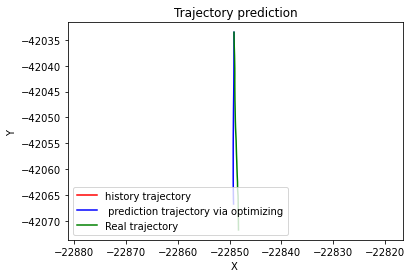

Test loss: 0.007055206218251914
MSE pre: 21.807337002548426
MSE RST: 1.8381606173974367
ADE_rst: 1.4525505064141035
FDE_rst: 3.49128407056529
ADE_pre: 6.333316365142724
FDE_pre: 7.254552075329178


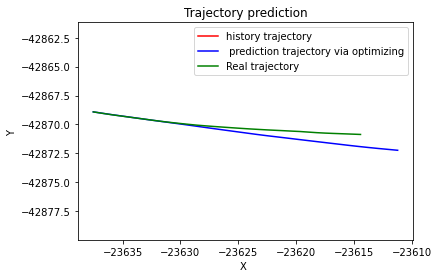

Test loss: 0.00831626171504153
MSE pre: 20.6178251842633
MSE RST: 4.8420689751287584
ADE_rst: 2.622738565513705
FDE_rst: 3.7701076804933233
ADE_pre: 6.059665769867137
FDE_pre: 7.237079687045936


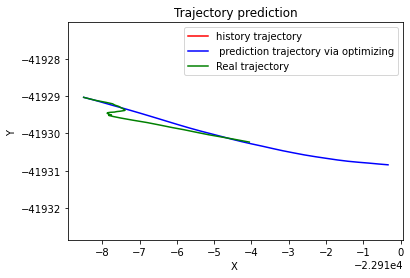

Test loss: 0.008879550013954391
MSE pre: 27.232837476126715
MSE RST: 0.6936513033059344
ADE_rst: 0.9924500105250658
FDE_rst: 1.9256584527862866
ADE_pre: 6.657467913751831
FDE_pre: 2.0825908601372407


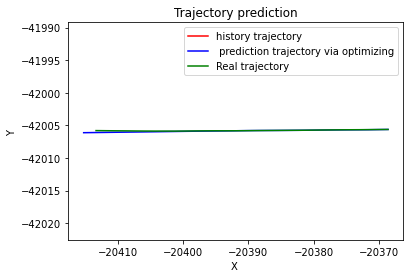

Test loss: 0.00666286373103513
MSE pre: 33.75847187081743
MSE RST: 0.15905401405075553
ADE_rst: 0.45743451222745996
FDE_rst: 0.9439306578970202
ADE_pre: 7.983805682939509
FDE_pre: 9.303818226436471


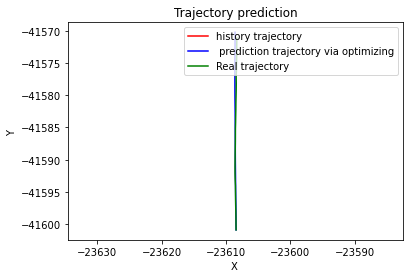

Test loss: 0.00892598906355006
MSE pre: 31.631122122883333
MSE RST: 0.5235274665185606
ADE_rst: 0.8900129980525981
FDE_rst: 1.690985199800175
ADE_pre: 6.953509513321863
FDE_pre: 3.2278185259158008


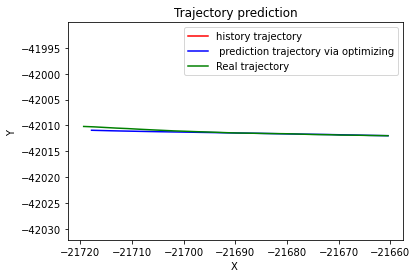

Test loss: 0.009919419307239573
MSE pre: 6.825640025839095
MSE RST: 0.5601902243431008
ADE_rst: 0.8628374399447079
FDE_rst: 2.066502503187166
ADE_pre: 3.14827954013762
FDE_pre: 8.785564423616847


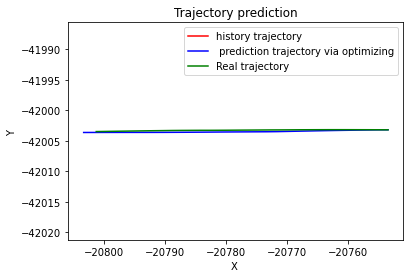

Test loss: 0.006697190781717987
MSE pre: 41.805300009816094
MSE RST: 5.159904474133661
ADE_rst: 2.349477856488156
FDE_rst: 7.159258116932962
ADE_pre: 7.61402284654647
FDE_pre: 16.200170044285088


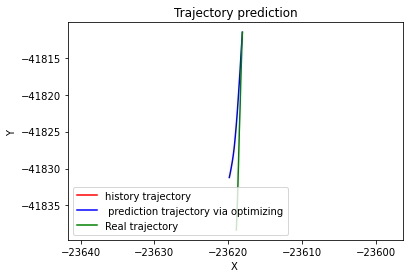

Test loss: 0.00748454781475993
MSE pre: 25.067622056996612
MSE RST: 0.3102410267397478
ADE_rst: 0.6396368714743507
FDE_rst: 1.1454654591711455
ADE_pre: 6.871713648989501
FDE_pre: 3.6246023177479616


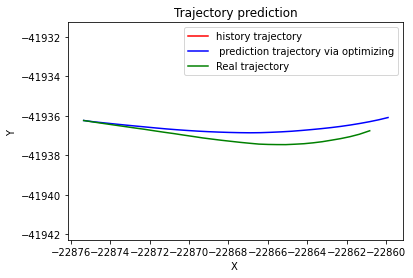

Test loss: 0.014315046809282856
MSE pre: 16.442399792660268
MSE RST: 0.22355565519713871
ADE_rst: 0.5942802905280172
FDE_rst: 1.0782944418798392
ADE_pre: 5.6911282285655975
FDE_pre: 6.264490290644087


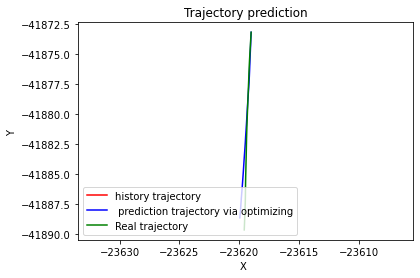

Test loss: 0.007913850624393452
MSE pre: 14.925589997156532
MSE RST: 1.0857614249213705
ADE_rst: 1.1685889016921966
FDE_rst: 2.795405145309854
ADE_pre: 5.112638006829223
FDE_pre: 6.847793192879248


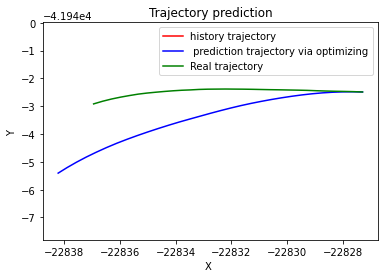

Test loss: 0.013776545339771186
MSE pre: 4.143021606611284
MSE RST: 0.5337636475312296
ADE_rst: 0.7806491128558188
FDE_rst: 2.2758499604241686
ADE_pre: 2.6049686670472965
FDE_pre: 6.6047700564776815


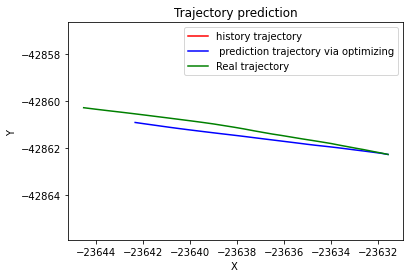

Test loss: 0.008795099229473833
MSE pre: 10.372204983476484
MSE RST: 8.29942458313711
ADE_rst: 3.28363952381199
FDE_rst: 4.450803355894962
ADE_pre: 4.131048993615157
FDE_pre: 1.5939730532514433


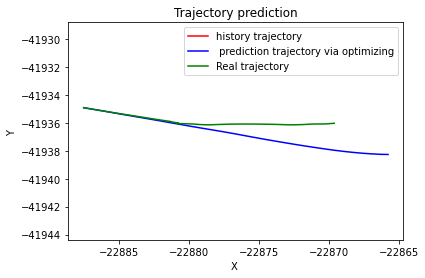

Test loss: 0.008441998987992963
MSE pre: 25.389173386080287
MSE RST: 0.31613155793548453
ADE_rst: 0.687968319054338
FDE_rst: 1.3718425147439233
ADE_pre: 6.233443408093993
FDE_pre: 8.255285194577512


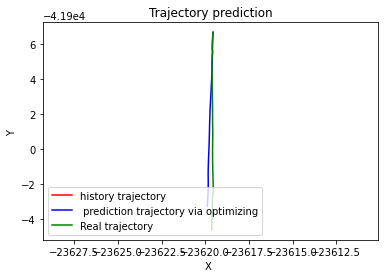

Test loss: 0.009343663267160837
MSE pre: 11.74413018485252
MSE RST: 1.8445143635694656
ADE_rst: 1.499145330094967
FDE_rst: 3.5296039390764986
ADE_pre: 4.679344955706966
FDE_pre: 8.082290566664033


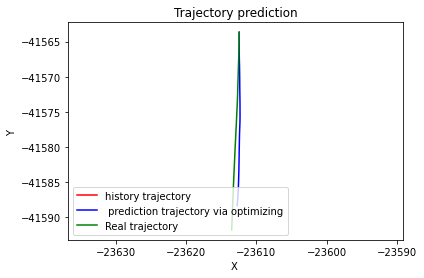

Test loss: 0.007770597182024339
MSE pre: 11.124535118342212
MSE RST: 3.411833682103635
ADE_rst: 2.2226527643677327
FDE_rst: 4.5482229687957565
ADE_pre: 3.60456321846894
FDE_pre: 11.282782935681533


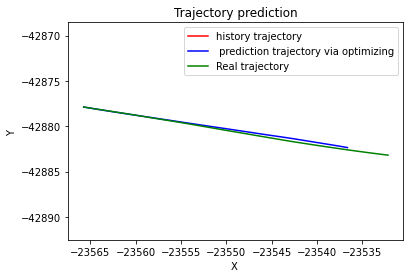

Test loss: 0.01465329402400363
MSE pre: 24.131791803631856
MSE RST: 1.0706100605151763
ADE_rst: 1.1888806884145695
FDE_rst: 3.17759038467911
ADE_pre: 6.60925213572573
FDE_pre: 2.8647482331577496


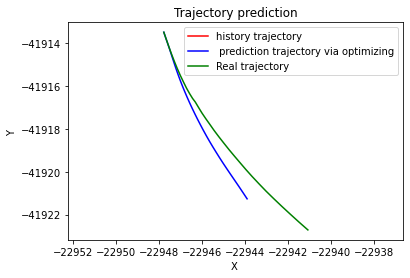

Test loss: 0.008992289156824656
MSE pre: 47.261159849651705
MSE RST: 5.458577654584547
ADE_rst: 2.794922388265093
FDE_rst: 5.3124239678901555
ADE_pre: 9.114339689178449
FDE_pre: 12.3601566769042


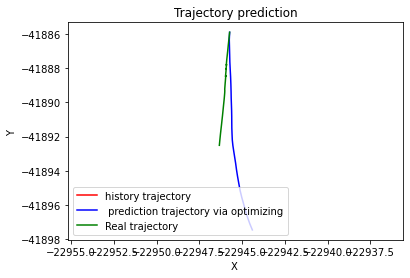

Test loss: 0.009555497665406453
MSE pre: 21.208919818335037
MSE RST: 1.3378936092323597
ADE_rst: 1.3070014576726552
FDE_rst: 2.6620612800349055
ADE_pre: 6.314375787645539
FDE_pre: 5.595878686829046


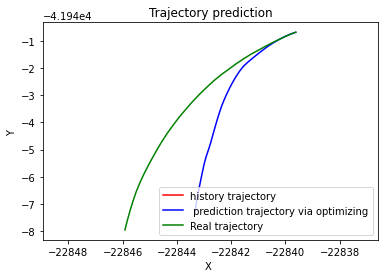

Test loss: 0.021090283740991474
MSE pre: 16.738281517285827
MSE RST: 2.261016152938485
ADE_rst: 1.601748533211196
FDE_rst: 4.664532756576884
ADE_pre: 5.106815130084998
FDE_pre: 11.713472869675265


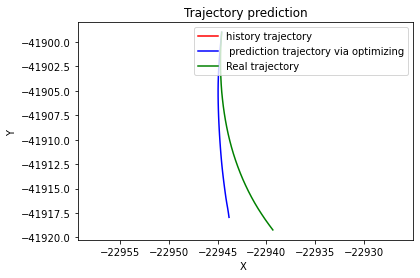

Test loss: 0.008572875806322213
MSE pre: 13.497018322916057
MSE RST: 0.9618439674168523
ADE_rst: 1.1411751407387485
FDE_rst: 2.54059922042536
ADE_pre: 4.891226123805016
FDE_pre: 5.942891457152786


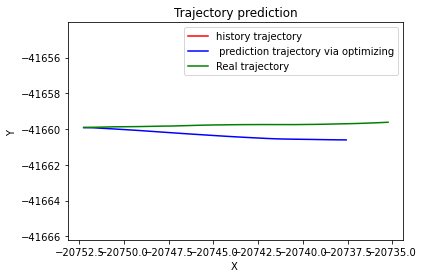

Test loss: 0.007706632039243277
MSE pre: 6.741557973242998
MSE RST: 0.10382904340584542
ADE_rst: 0.3514971730013489
FDE_rst: 1.1438281825397942
ADE_pre: 3.309960818455538
FDE_pre: 6.49837663640624


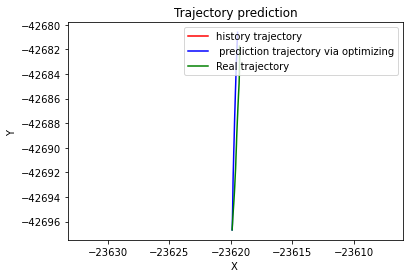

Test loss: 0.011894250571303095
MSE pre: 13.123271097661771
MSE RST: 1.9872383212762366
ADE_rst: 1.486422935396772
FDE_rst: 4.659705905767253
ADE_pre: 4.557515825903092
FDE_pre: 4.61922481691473


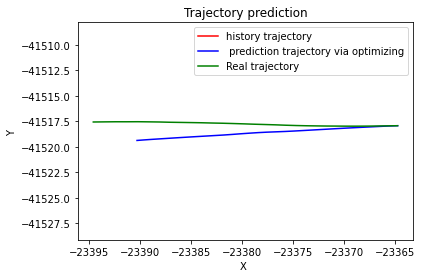

Test loss: 0.008179217927195708
MSE pre: 6.8120632793429
MSE RST: 0.10755056547733766
ADE_rst: 0.43375976155304646
FDE_rst: 0.5837684470005357
ADE_pre: 3.2565420201118376
FDE_pre: 5.7071131088657046


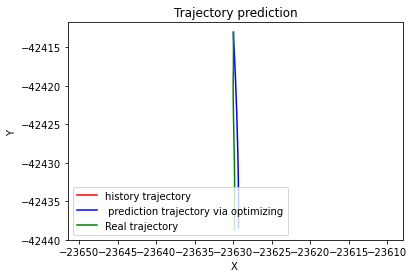

Test loss: 0.0068051468270121955
MSE pre: 32.74817565101141
MSE RST: 0.07095853754751277
ADE_rst: 0.29982345111705944
FDE_rst: 0.579103070995475
ADE_pre: 7.798356796690059
FDE_pre: 3.674861721486198


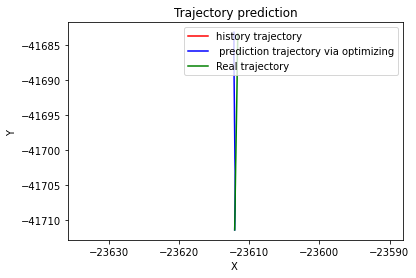

Test loss: 0.01519555946044953
MSE pre: 4.774511900548141
MSE RST: 0.37510618244875726
ADE_rst: 0.6421955646165489
FDE_rst: 1.7862320993048748
ADE_pre: 2.9153379006563727
FDE_pre: 6.7430786864065455


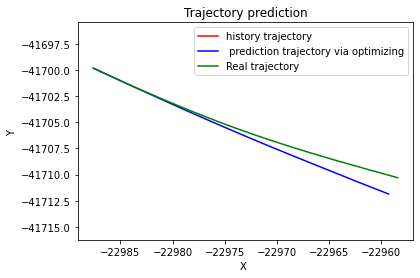

Test loss: 0.006598855086816441
MSE pre: 53.74665758037729
MSE RST: 0.5649238157835443
ADE_rst: 0.8674034772292357
FDE_rst: 1.9860658509981561
ADE_pre: 10.2686626470628
FDE_pre: 10.238794715296297


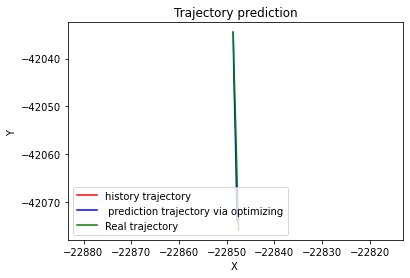

Test loss: 0.013802938484301192
MSE pre: 3.419734400162571
MSE RST: 0.2780606291962405
ADE_rst: 0.577109925598659
FDE_rst: 1.6741625642150986
ADE_pre: 2.531785164095591
FDE_pre: 3.9623036851633704


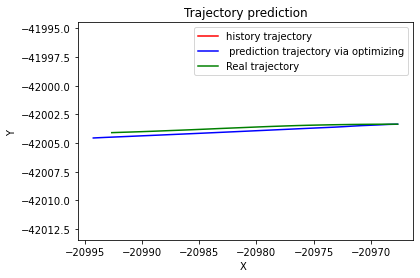

Test loss: 0.006940105851877539
MSE pre: 25.238095491515313
MSE RST: 0.08354370292355422
ADE_rst: 0.3248554901778694
FDE_rst: 0.8343063979547157
ADE_pre: 6.82084942775671
FDE_pre: 5.952348801977313


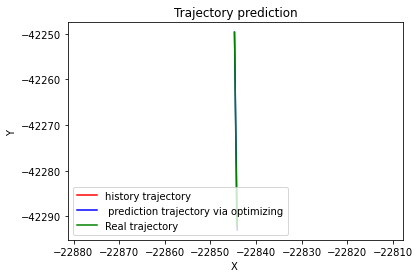

Test loss: 0.009013552795975323
MSE pre: 16.1154418199258
MSE RST: 0.26883963974425934
ADE_rst: 0.6678352208803008
FDE_rst: 0.9616474046484736
ADE_pre: 5.5934411800929595
FDE_pre: 9.18234112894042


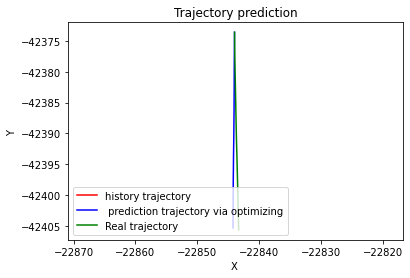

Test loss: 0.00621122466689193
MSE pre: 10.710326861486022
MSE RST: 3.2753678737839818
ADE_rst: 2.048868384550502
FDE_rst: 5.209749410754102
ADE_pre: 4.233730963764885
FDE_pre: 6.593942447347714


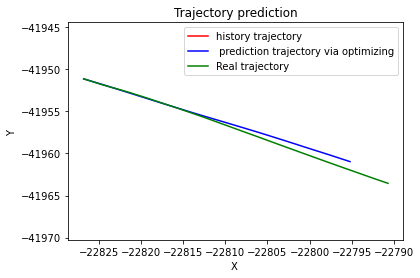

Test loss: 0.008131927920895229
MSE pre: 46.66725529589321
MSE RST: 0.21924325237878664
ADE_rst: 0.5448239215643925
FDE_rst: 1.3965170668101563
ADE_pre: 8.776383533415942
FDE_pre: 3.718093560430854


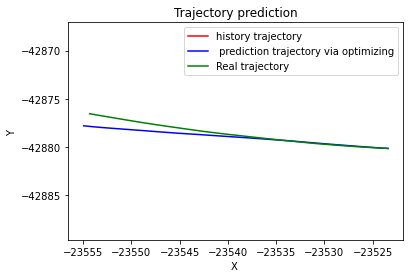

Test loss: 0.006068720326026044
MSE pre: 47.17236644129179
MSE RST: 1.7993904364847337
ADE_rst: 1.6246292413836887
FDE_rst: 3.116168109687689
ADE_pre: 9.090423617967607
FDE_pre: 4.107485042164448


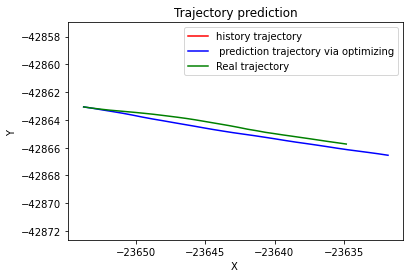

Test loss: 0.010897243987602681
MSE pre: 13.726840977018766
MSE RST: 2.4669041476732945
ADE_rst: 1.8366664560061527
FDE_rst: 4.1550269365940755
ADE_pre: 5.019347941849675
FDE_pre: 8.989041876581616


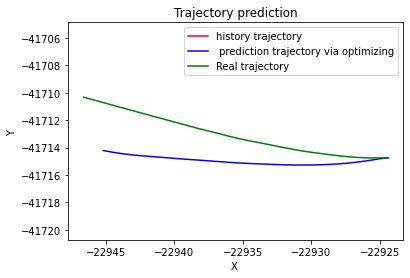

Test loss: 0.0076319104932408895
MSE pre: 22.206544275565918
MSE RST: 0.15239507520985796
ADE_rst: 0.486466358358136
FDE_rst: 0.8435910175043513
ADE_pre: 5.6714257151556
FDE_pre: 5.449895229263764


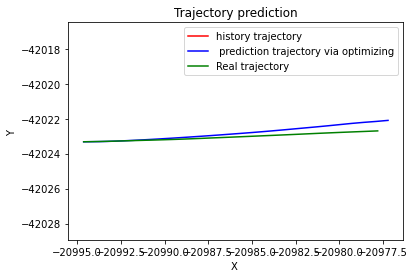

Test loss: 0.008155279930321798
MSE pre: 10.509441836589737
MSE RST: 0.43916062903863
ADE_rst: 0.6915620211238415
FDE_rst: 2.0670081712997557
ADE_pre: 4.354265697261646
FDE_pre: 2.3775097530978706


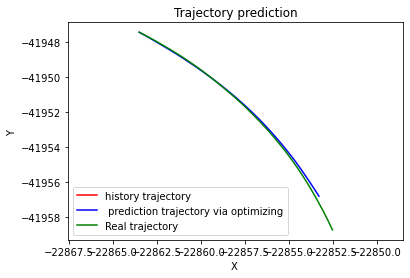

Test loss: 0.008399314556681223
MSE pre: 7.8596068446145875
MSE RST: 0.9437841611029213
ADE_rst: 1.2043764800537589
FDE_rst: 2.102432678607864
ADE_pre: 3.528410289336697
FDE_pre: 3.2588403602375013


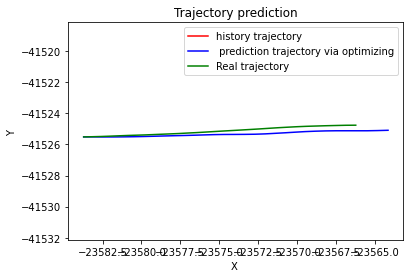

Test loss: 0.007984234192373428
MSE pre: 4.668098006646174
MSE RST: 0.3352620300747418
ADE_rst: 0.6896755783321429
FDE_rst: 1.5719594289012913
ADE_pre: 2.894484633197764
FDE_pre: 4.53027883563957


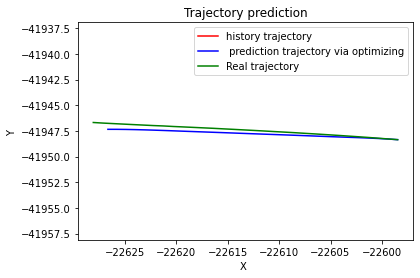

Test loss: 0.009006909524473779
MSE pre: 7.592758193057626
MSE RST: 0.9145455658853687
ADE_rst: 1.0029184004227256
FDE_rst: 2.8452810791575986
ADE_pre: 3.776582283823324
FDE_pre: 1.4005532262256513


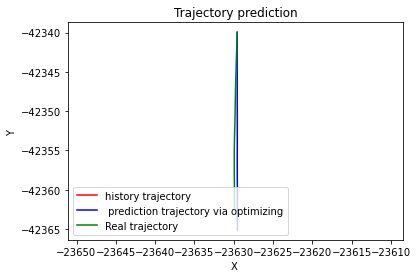

Test loss: 0.007254126399467439
MSE pre: 6.463970254575142
MSE RST: 0.09715922224012931
ADE_rst: 0.3919743206506543
FDE_rst: 0.6980908959412183
ADE_pre: 3.3553277759514626
FDE_pre: 5.698347929244799


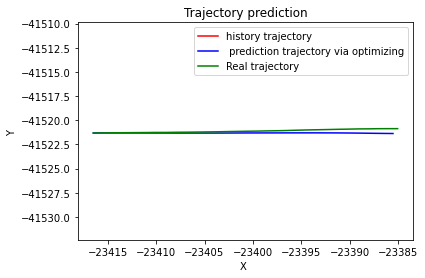

Test loss: 0.009552631809413183
MSE pre: 25.759447667727358
MSE RST: 0.26913658778244975
ADE_rst: 0.6329805995507223
FDE_rst: 1.141585889726407
ADE_pre: 6.902789332094857
FDE_pre: 11.869134065875048


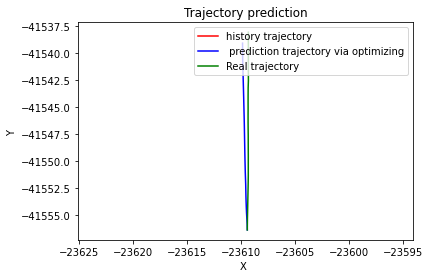

Test loss: 0.007891503645942375
MSE pre: 13.337284504331917
MSE RST: 1.3487468472667117
ADE_rst: 1.392837457626673
FDE_rst: 2.7570018197430497
ADE_pre: 4.955701389333228
FDE_pre: 5.639022695735248


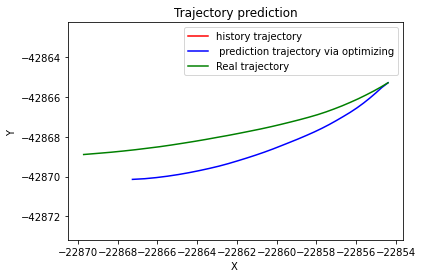

Test loss: 0.00792209067508071
MSE pre: 31.811268587111613
MSE RST: 0.0871891740641164
ADE_rst: 0.33974239507716153
FDE_rst: 0.9055950050386374
ADE_pre: 7.715489135043805
FDE_pre: 5.695011280402614


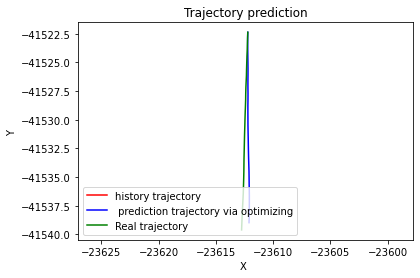

Test loss: 0.0071864309683972215
MSE pre: 18.791313779667597
MSE RST: 0.08260927383211143
ADE_rst: 0.3574475508418168
FDE_rst: 0.5925700136625903
ADE_pre: 5.781662393572678
FDE_pre: 2.0583981192658354


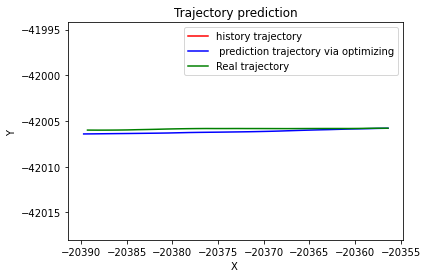

Test loss: 0.007481856120941316
MSE pre: 3.5228428093754696
MSE RST: 0.8654065905971028
ADE_rst: 0.9942401013857093
FDE_rst: 2.822600739868954
ADE_pre: 2.500366185582712
FDE_pre: 2.4612156872688553


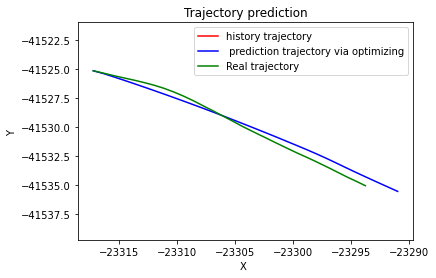

Test loss: 0.0067849259328111875
MSE pre: 8.889375241037403
MSE RST: 0.18840906642492122
ADE_rst: 0.5269489572206303
FDE_rst: 1.3289282554139972
ADE_pre: 3.8730428228739657
FDE_pre: 6.823688250967799


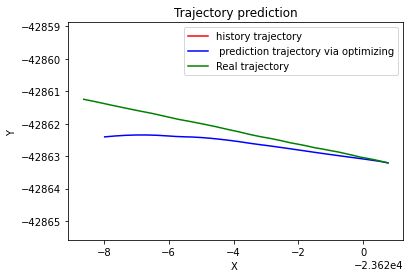

Test loss: 0.009989519736477503
MSE pre: 9.106250825553538
MSE RST: 1.2542013433969328
ADE_rst: 1.229601141956607
FDE_rst: 2.9168656975501817
ADE_pre: 3.915411449034526
FDE_pre: 3.619148954508159


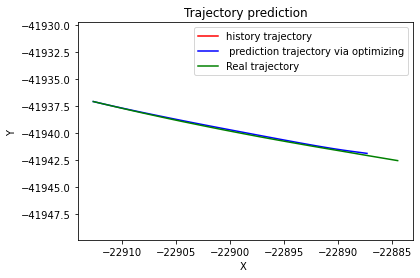

Test loss: 0.014658119019878188
MSE pre: 45.57936684859804
MSE RST: 0.5026746580496751
ADE_rst: 0.7539179378497658
FDE_rst: 2.1333515152469027
ADE_pre: 8.854989867136064
FDE_pre: 1.132869228279206


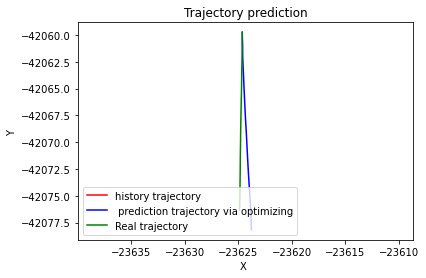

Test loss: 0.008259153654191326
MSE pre: 91.81666506088875
MSE RST: 0.2336776318338766
ADE_rst: 0.48958966700732154
FDE_rst: 1.4484247611340175
ADE_pre: 12.976634856591824
FDE_pre: 30.29738029843911


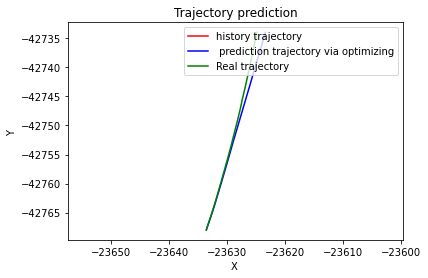

Test loss: 0.00843030791831612
MSE pre: 55.42635051316669
MSE RST: 0.8032403378355257
ADE_rst: 1.015751180460574
FDE_rst: 2.4731340912433795
ADE_pre: 9.505298073770742
FDE_pre: 6.658784805127444


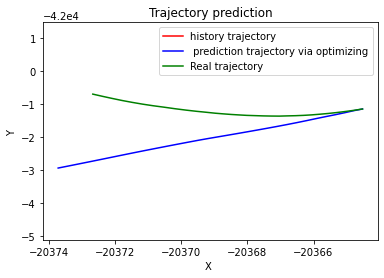

Test loss: 0.007799851818446899
MSE pre: 8.494788400864671
MSE RST: 3.479594103339973
ADE_rst: 2.1395438741424133
FDE_rst: 5.205076741363794
ADE_pre: 3.5365601001728586
FDE_pre: 0.5416806371765263


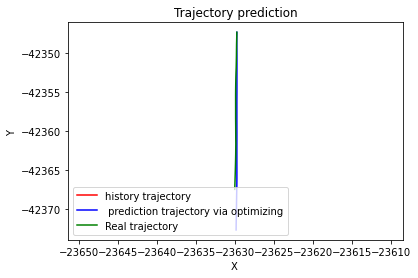

Test loss: 0.006776355572336086
MSE pre: 48.02325379132103
MSE RST: 2.44042475931423
ADE_rst: 1.5683408192502397
FDE_rst: 4.852960955664732
ADE_pre: 9.040030657475091
FDE_pre: 8.576424888884864


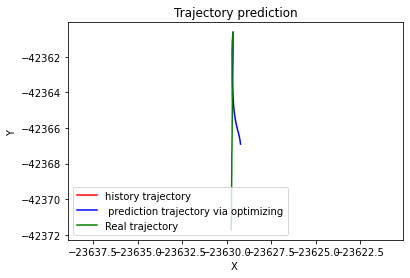

Test loss: 0.008383478084799677
MSE pre: 23.444488311789495
MSE RST: 0.4888610980835222
ADE_rst: 0.7132818814126518
FDE_rst: 2.3609486991634148
ADE_pre: 5.640779558717656
FDE_pre: 0.3363365396534236


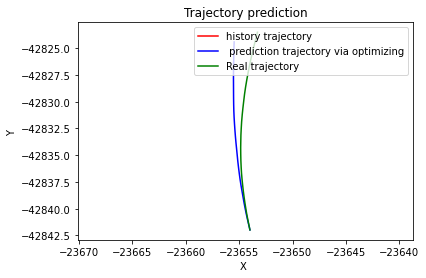

Test loss: 0.007728891010228274
MSE pre: 7.961616251076043
MSE RST: 0.9184794312819763
ADE_rst: 0.9783196792649783
FDE_rst: 2.7740806270076375
ADE_pre: 3.2243265035118664
FDE_pre: 5.186685246863114


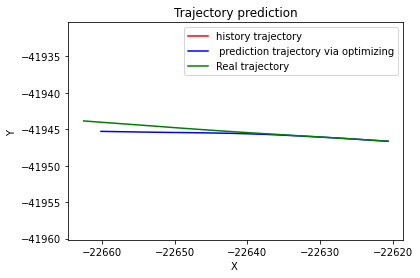

Test loss: 0.009520642016136994
MSE pre: 7.981605075436942
MSE RST: 0.6055374018222646
ADE_rst: 0.9282058352407929
FDE_rst: 1.9037499814343202
ADE_pre: 3.7405622001631684
FDE_pre: 5.382987180564724


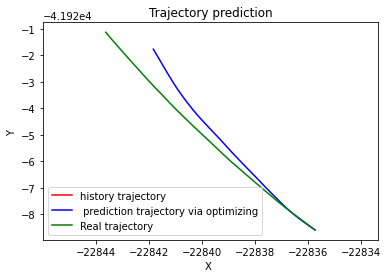

Test loss: 0.008237530155979915
MSE pre: 36.33524982404331
MSE RST: 1.280972785317973
ADE_rst: 1.3421030572597243
FDE_rst: 2.770556091231073
ADE_pre: 8.444870314188721
FDE_pre: 9.491401485631384


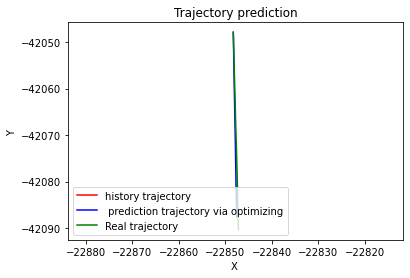

Test loss: 0.007394449551650754
MSE pre: 1.8569177799226069
MSE RST: 0.20427009613278962
ADE_rst: 0.46505867743075474
FDE_rst: 1.5763928395682352
ADE_pre: 1.794252343018911
FDE_pre: 2.309527471601941


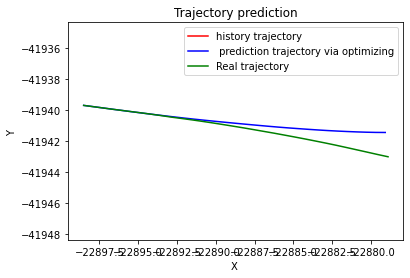

Test loss: 0.008430106987134927
MSE pre: 7.548088238737723
MSE RST: 1.303557792327113
ADE_rst: 1.3315494875237852
FDE_rst: 3.1671434748916587
ADE_pre: 3.454021602866098
FDE_pre: 8.794888485166176


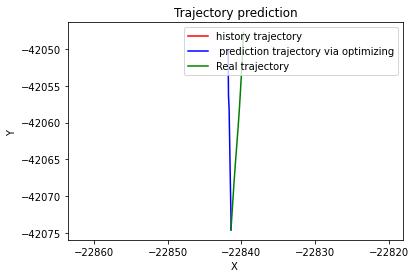

Test loss: 0.007586357218606533
MSE pre: 85.57574119032519
MSE RST: 0.2649683731665477
ADE_rst: 0.6295497578058925
FDE_rst: 1.1268177601067748
ADE_pre: 12.303742125823668
FDE_pre: 17.836867552913713


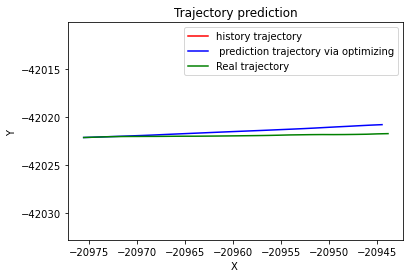

Test loss: 0.00832986186197906
MSE pre: 10.705791143946097
MSE RST: 2.8729927381225067
ADE_rst: 1.8769136726612916
FDE_rst: 4.782400790822141
ADE_pre: 4.478447840731791
FDE_pre: 2.8546073493776336


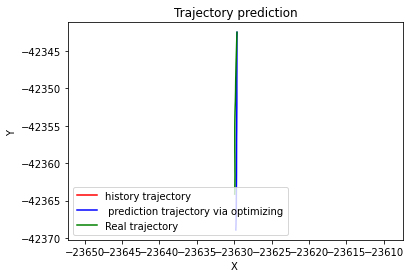

Test loss: 0.014059748399640252
MSE pre: 3.4813771472517105
MSE RST: 0.004789126188328751
ADE_rst: 0.09053523752100515
FDE_rst: 0.10953904734597582
ADE_pre: 2.4726218555761155
FDE_pre: 5.645824637794843


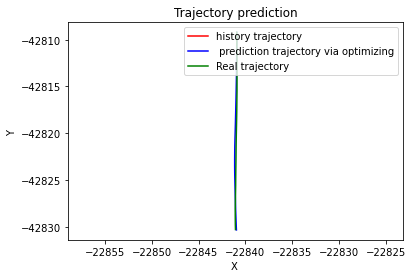

Test loss: 0.008718620510087224
MSE pre: 37.15128881059505
MSE RST: 0.11288983792410494
ADE_rst: 0.41258708141914024
FDE_rst: 0.8181688711587541
ADE_pre: 7.9874273258104065
FDE_pre: 1.4753058456742763


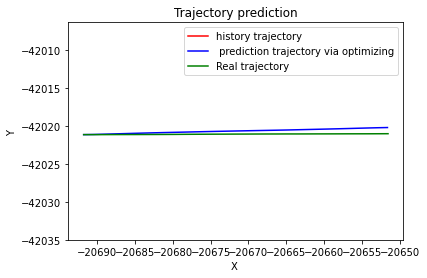

Test loss: 0.0051593081640698155
MSE pre: 7.950045081806534
MSE RST: 1.4905704796967427
ADE_rst: 1.279966483338159
FDE_rst: 3.6671763747668633
ADE_pre: 3.6990758506154404
FDE_pre: 6.519007863444456


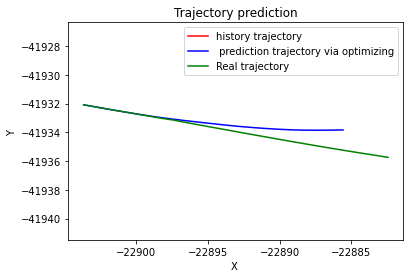

Test loss: 0.008200635681388832
MSE pre: 14.150621764814902
MSE RST: 0.641229879681016
ADE_rst: 0.9918710070281135
FDE_rst: 0.8014833791238221
ADE_pre: 5.119891115955177
FDE_pre: 3.2171311931309825


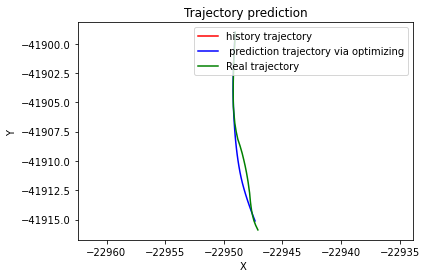

Test loss: 0.0076093546881001025
MSE pre: 28.80351663652957
MSE RST: 4.611528399660002
ADE_rst: 2.513952545984898
FDE_rst: 5.900587833191888
ADE_pre: 7.364116250070616
FDE_pre: 7.63914229958725


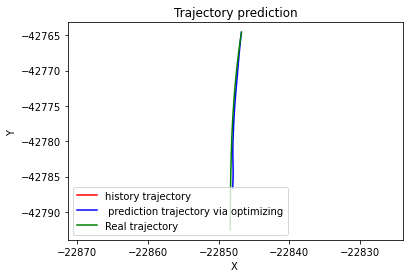

Test loss: 0.007731422072890106
MSE pre: 65.56911017758651
MSE RST: 0.8213557962832276
ADE_rst: 0.9211530006146703
FDE_rst: 2.891738612195427
ADE_pre: 10.17046345990891
FDE_pre: 3.1242414355358026


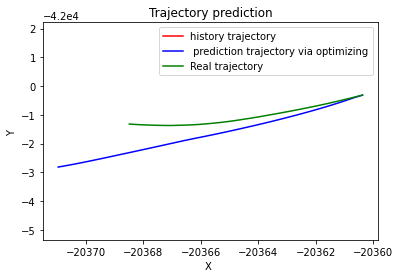

Test loss: 0.006120740978926933
MSE pre: 44.412430007440825
MSE RST: 0.13096172911369597
ADE_rst: 0.439169041850041
FDE_rst: 0.8557509663491362
ADE_pre: 8.76388509859513
FDE_pre: 2.876620268254843


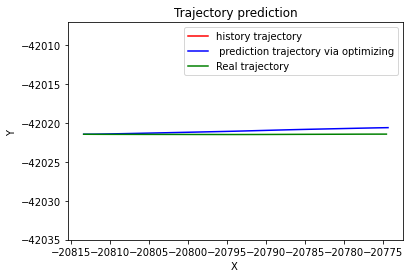

Test loss: 0.008755322624938042
MSE pre: 6.193076195655876
MSE RST: 0.21363469618003333
ADE_rst: 0.5670157504027356
FDE_rst: 0.5740987831691172
ADE_pre: 3.308976516871562
FDE_pre: 6.6837357082939945


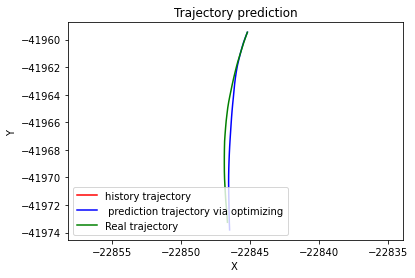

Test loss: 0.011091374852839155
MSE pre: 40.68358814574435
MSE RST: 0.30553753435747777
ADE_rst: 0.6821585502823603
FDE_rst: 1.1147327192201633
ADE_pre: 8.941085991749288
FDE_pre: 9.582545592076324


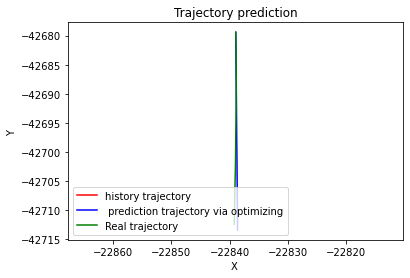

Test loss: 0.008637763345742509
MSE pre: 8.365893051375144
MSE RST: 0.10095024845104343
ADE_rst: 0.3568065285061421
FDE_rst: 0.9892535574640794
ADE_pre: 3.692218214057337
FDE_pre: 2.821512891790234


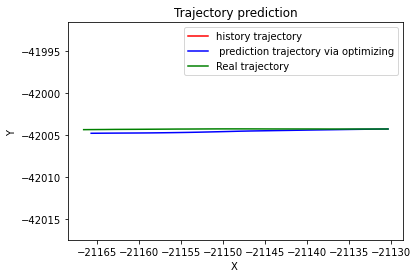

Test loss: 0.007528742929485101
MSE pre: 16.06539775958529
MSE RST: 0.49353685672032155
ADE_rst: 0.6982001374517389
FDE_rst: 2.3117671463695184
ADE_pre: 5.3983374537117825
FDE_pre: 2.817726902673806


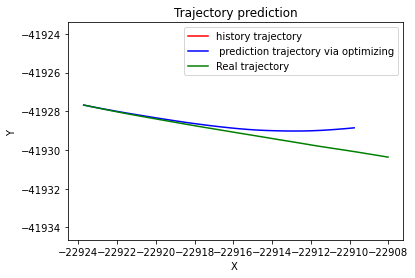

Test loss: 0.011290302192264188
MSE pre: 124.49730006522678
MSE RST: 1.9532258190356837
ADE_rst: 1.6174008580192436
FDE_rst: 3.5444499602822064
ADE_pre: 14.898045790448863
FDE_pre: 8.78839661748687


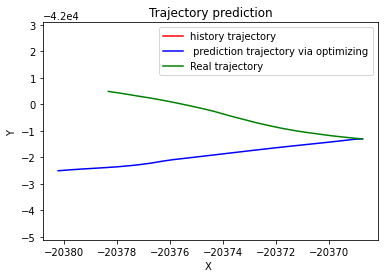

Test loss: 0.00844096229517732
MSE pre: 1.2681637920674982
MSE RST: 0.2297019887297229
ADE_rst: 0.5289309528730682
FDE_rst: 1.3604029429961468
ADE_pre: 1.494778090356256
FDE_pre: 2.8283640316706484


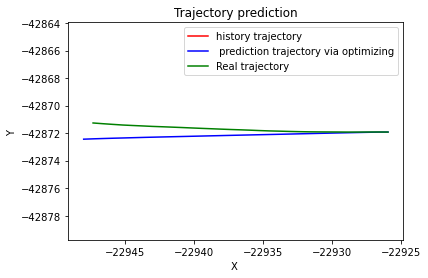

Test loss: 0.011013967306226129
MSE pre: 20.743658225857963
MSE RST: 2.1617774351330366
ADE_rst: 1.5715472393316352
FDE_rst: 4.335723264028881
ADE_pre: 6.34174213211021
FDE_pre: 6.416717085523852


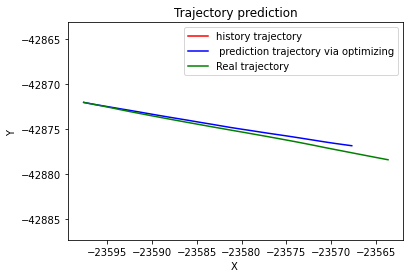

Test loss: 0.013986369797133198
MSE pre: 79.71427921339347
MSE RST: 0.3924975210559033
ADE_rst: 0.7295473581407955
FDE_rst: 1.433513784017797
ADE_pre: 12.246453282924662
FDE_pre: 7.818993190135425


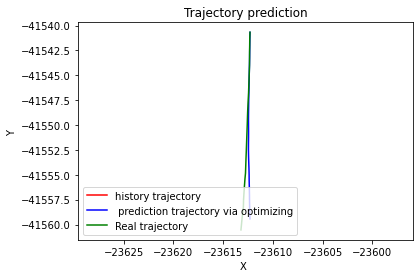

Test loss: 0.007131433724975472
MSE pre: 27.633331386558996
MSE RST: 0.8905756393697518
ADE_rst: 1.13663198130794
FDE_rst: 2.5282626627145244
ADE_pre: 7.1153716473477635
FDE_pre: 7.8959785470047725


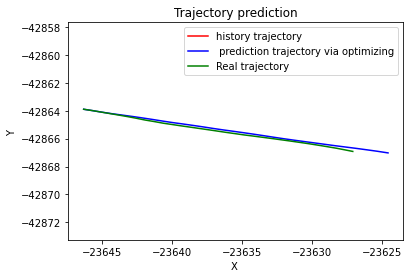

Test loss: 0.007661908026576842
MSE pre: 62.90444239274137
MSE RST: 0.1584520360888647
ADE_rst: 0.4748640315866994
FDE_rst: 1.241157451538608
ADE_pre: 10.761982362708801
FDE_pre: 20.166154680198005


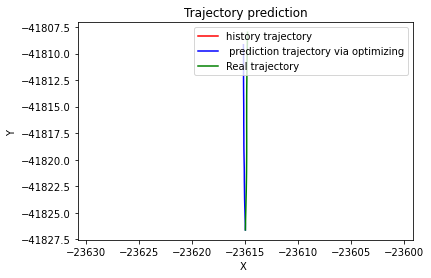

Test loss: 0.007258554935140067
MSE pre: 39.375975166914806
MSE RST: 0.12277534156333396
ADE_rst: 0.44491079485761825
FDE_rst: 0.79441152808901
ADE_pre: 7.995080297335976
FDE_pre: 16.017024262973397


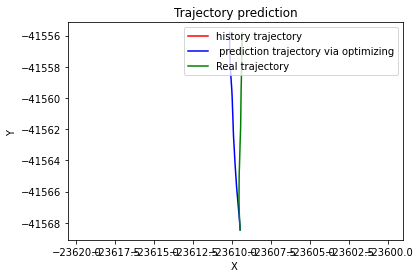

Test loss: 0.00754587597850182
MSE pre: 10.937259278326154
MSE RST: 0.22078987967917751
ADE_rst: 0.514258611173864
FDE_rst: 1.3440545177987326
ADE_pre: 4.0707024609731315
FDE_pre: 3.203723601203095


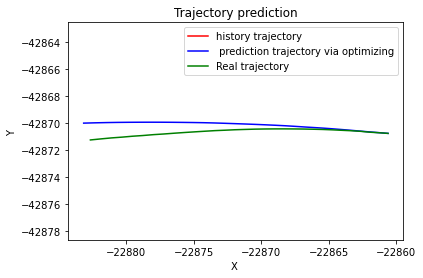

Test loss: 0.014306540193182261
MSE pre: 19.043578241608728
MSE RST: 1.2125241343856246
ADE_rst: 1.3705093090880607
FDE_rst: 2.7039766223807558
ADE_pre: 5.640170817584895
FDE_pre: 5.302577304901345


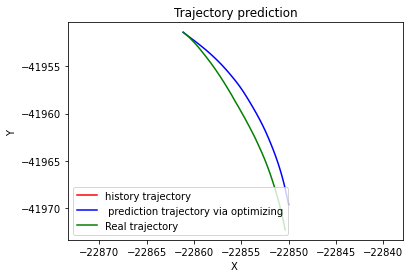

Test loss: 0.009670215877232336
MSE pre: 147.5278172904764
MSE RST: 1.7302898808119687
ADE_rst: 1.516734635709942
FDE_rst: 3.0626170844098435
ADE_pre: 15.554131125652088
FDE_pre: 7.577958998958881


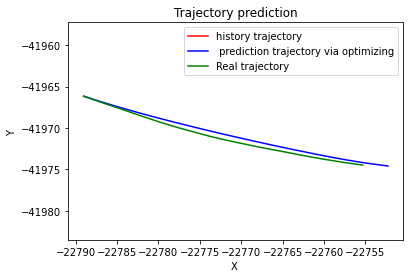

Test loss: 0.011007132869226905
MSE pre: 35.253561984393606
MSE RST: 1.1055274896611964
ADE_rst: 1.2541079918070557
FDE_rst: 2.566872931691984
ADE_pre: 7.9340157145967085
FDE_pre: 4.033343541360817


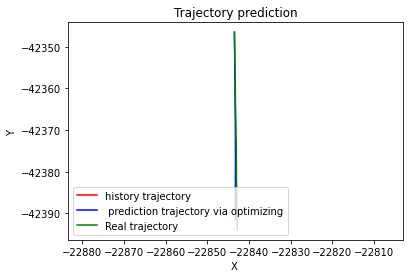

Test loss: 0.014362778671498414
MSE pre: 6.403804626410557
MSE RST: 7.339212623893353
ADE_rst: 2.962666973199806
FDE_rst: 7.563733021372794
ADE_pre: 2.829598742093404
FDE_pre: 10.532209430070726


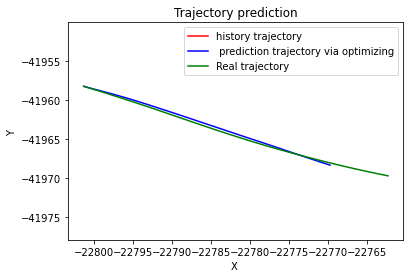

Test loss: 0.008067787430275418
MSE pre: 97.2431463422537
MSE RST: 1.5356987745785982
ADE_rst: 1.329095405045573
FDE_rst: 3.7879287952051275
ADE_pre: 12.694628198324738
FDE_pre: 9.968237449733877


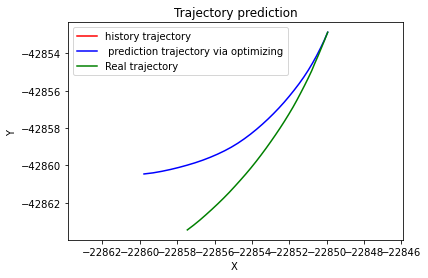

Test loss: 0.008994243632488198
MSE pre: 19.629583194008088
MSE RST: 0.8503846359648988
ADE_rst: 0.9237397032321327
FDE_rst: 2.9390008745193428
ADE_pre: 6.102224227556478
FDE_pre: 5.47605848429951


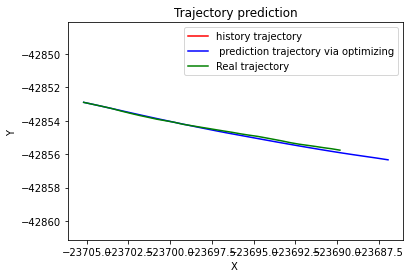

Test loss: 0.01030922707046803
MSE pre: 9.715991189762692
MSE RST: 2.121376662427312
ADE_rst: 1.6399303359952486
FDE_rst: 4.087645858738296
ADE_pre: 3.6302396671828006
FDE_pre: 4.573405955068365


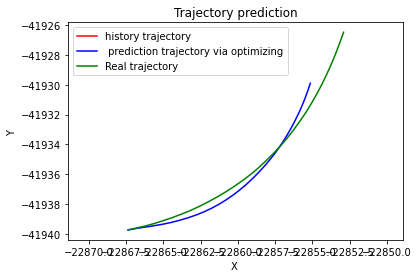

Test loss: 0.00728865836492688
MSE pre: 35.21785336317979
MSE RST: 1.065318131358811
ADE_rst: 1.2336900309379863
FDE_rst: 2.5130907968090694
ADE_pre: 7.914843778573625
FDE_pre: 3.81759589886009


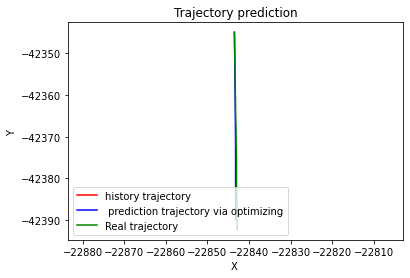

Test loss: 0.006775135495876637
MSE pre: 11.034074161999056
MSE RST: 0.15586998797816803
ADE_rst: 0.47242692633212047
FDE_rst: 1.0543374796414269
ADE_pre: 4.341030641281019
FDE_pre: 6.233970577288675


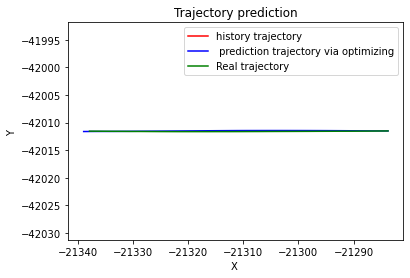

Test loss: 0.008134832844648549
MSE pre: 34.283280041938355
MSE RST: 0.17735253728428974
ADE_rst: 0.494400287917477
FDE_rst: 1.288850157353338
ADE_pre: 8.061218848345861
FDE_pre: 4.114385679000585


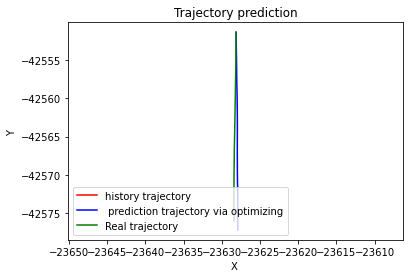

Test loss: 0.009974181837423803
MSE pre: 13.195164740417352
MSE RST: 0.7633475523504893
ADE_rst: 1.0758299091020413
FDE_rst: 1.827203147055851
ADE_pre: 5.004116167579064
FDE_pre: 2.174246833787003


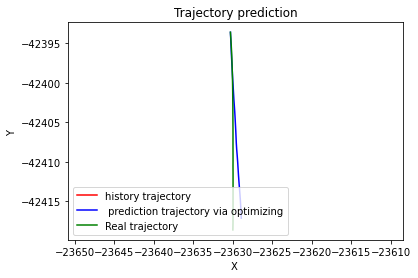

Test loss: 0.008068447406110237
MSE pre: 15.647824106182643
MSE RST: 0.05872452123009545
ADE_rst: 0.26556908811202384
FDE_rst: 0.6921828681724167
ADE_pre: 5.43314623584921
FDE_pre: 1.0118981843632235


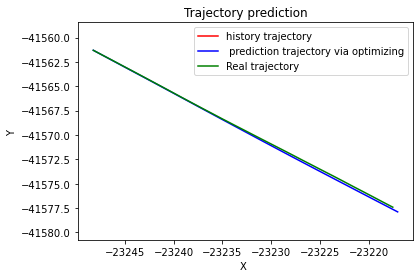

Test loss: 0.013199094653550784
MSE pre: 28.909814299797837
MSE RST: 0.49405189261484606
ADE_rst: 0.8858325419663774
FDE_rst: 1.5985035756177637
ADE_pre: 7.457223976382575
FDE_pre: 7.8879395139752475


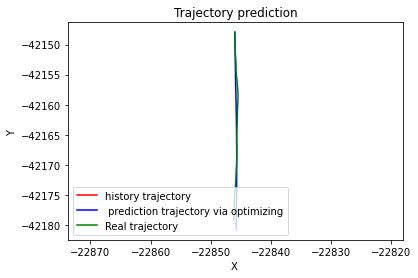

Test loss: 0.009294822772524781
MSE pre: 53.16585158085111
MSE RST: 0.04719095580452567
ADE_rst: 0.25603571590730373
FDE_rst: 0.4281812316335269
ADE_pre: 9.410584040640341
FDE_pre: 2.593353416709571


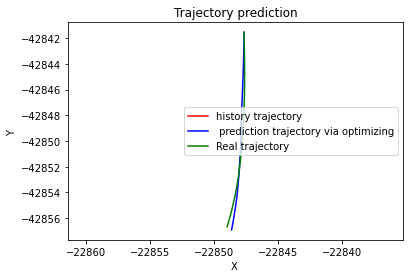

Test loss: 0.0074826445290018355
MSE pre: 62.413724765566
MSE RST: 0.7788089013227386
ADE_rst: 1.0368625188673928
FDE_rst: 3.018975154515009
ADE_pre: 10.730475750230505
FDE_pre: 9.181069906932947


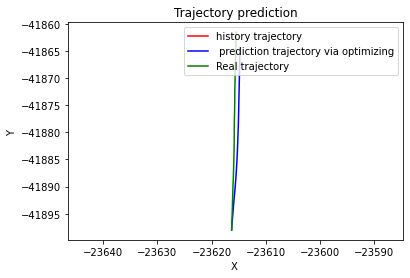

Test loss: 0.009348237544052609
MSE pre: 19.344363965650135
MSE RST: 1.985196854006721
ADE_rst: 1.543512302434958
FDE_rst: 3.971387928250822
ADE_pre: 5.753126176901333
FDE_pre: 7.999541939873981


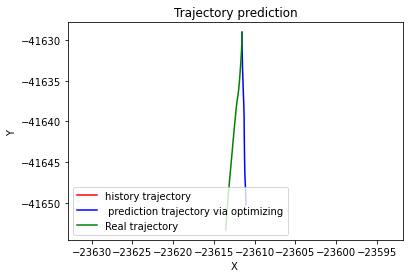

Test loss: 0.009636513740625118
MSE pre: 18.795960998419265
MSE RST: 0.8185741558886912
ADE_rst: 1.06845249206678
FDE_rst: 2.3123802971060154
ADE_pre: 5.829813261789605
FDE_pre: 6.582021816539034


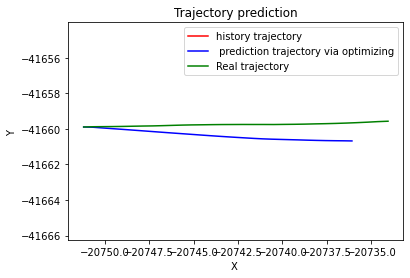

Test loss: 0.009386590654613405
MSE pre: 12.619511267145295
MSE RST: 0.02930008896035938
ADE_rst: 0.2128134751033881
FDE_rst: 0.39013083384633895
ADE_pre: 4.407402141583081
FDE_pre: 3.5476634339035567


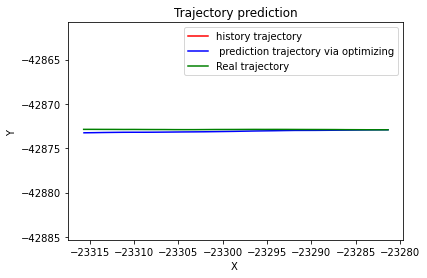

Test loss: 0.007373793901508302
MSE pre: 27.446460521976228
MSE RST: 0.6473455834674453
ADE_rst: 1.0369447870969677
FDE_rst: 1.4045577704909562
ADE_pre: 6.834542178043092
FDE_pre: 4.439133106002368


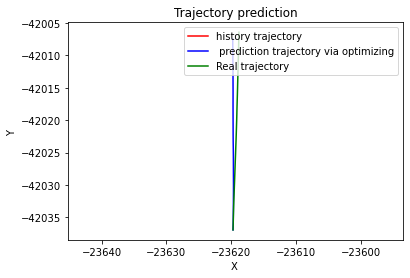

Test loss: 0.008156012648297569
MSE pre: 32.21869290936943
MSE RST: 0.12539945769394398
ADE_rst: 0.4320071686560913
FDE_rst: 1.0075847960674327
ADE_pre: 7.828545431931075
FDE_pre: 7.350814469668539


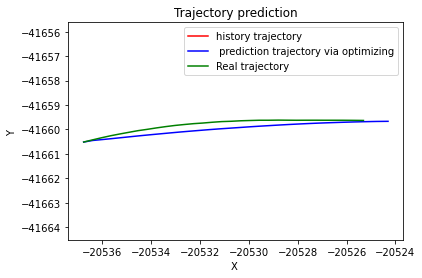

Test loss: 0.008597459133790562
MSE pre: 15.806324463217779
MSE RST: 2.00007813419148
ADE_rst: 1.5888807446597886
FDE_rst: 3.852410311261769
ADE_pre: 5.404986707109215
FDE_pre: 5.902698693006063


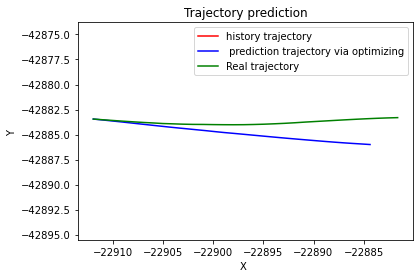

Test loss: 0.010500797264938804
MSE pre: 11.852182858572924
MSE RST: 1.063966089102776
ADE_rst: 1.2374039417593161
FDE_rst: 2.158494805826266
ADE_pre: 4.571758011359442
FDE_pre: 7.19249299128024


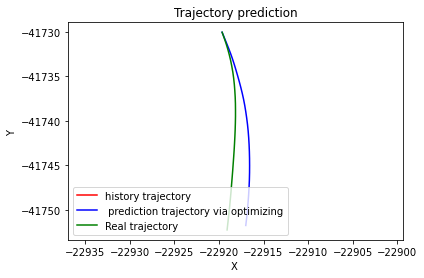

Test loss: 0.007969221102714898
MSE pre: 10.054860234840175
MSE RST: 0.4324139403938838
ADE_rst: 0.7685923364854094
FDE_rst: 1.299312767634141
ADE_pre: 4.022739553600208
FDE_pre: 5.464849064265786


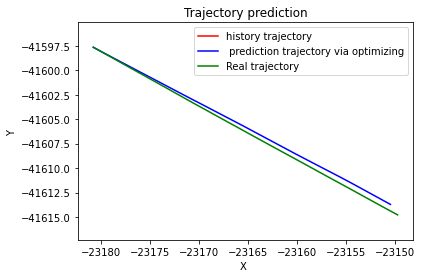

Test loss: 0.00693218635969688
MSE pre: 13.235935418610817
MSE RST: 0.09204474470375072
ADE_rst: 0.3543156723325561
FDE_rst: 0.7153231266247656
ADE_pre: 4.701023210698497
FDE_pre: 2.9197870797308076


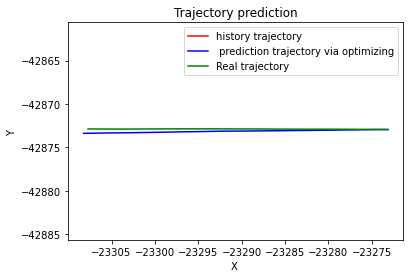

Test loss: 0.00750788952220214
MSE pre: 27.733641338771253
MSE RST: 0.05885065315268295
ADE_rst: 0.20532515047349617
FDE_rst: 1.097756429233852
ADE_pre: 7.101334924551839
FDE_pre: 15.79911344026773


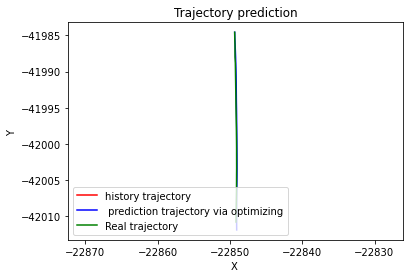

Test loss: 0.0072084707783103335
MSE pre: 10.132196787588324
MSE RST: 0.22051027397650938
ADE_rst: 0.5693519738322368
FDE_rst: 1.2182297685993468
ADE_pre: 3.950375864290948
FDE_pre: 11.420004260798729


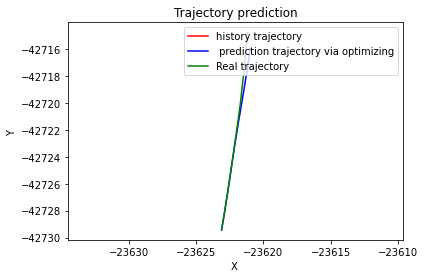

Test loss: 0.008858878633050635
MSE pre: 81.81649953894436
MSE RST: 0.6100885159363577
ADE_rst: 0.9217477048520912
FDE_rst: 2.0491461324361646
ADE_pre: 12.48138748762868
FDE_pre: 8.723539784855511


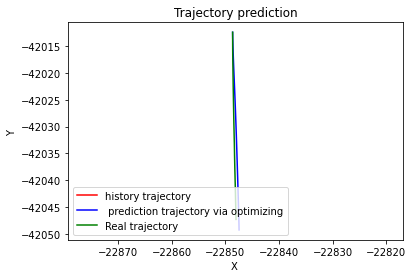

Test loss: 0.010899096783566209
MSE pre: 19.11867510725865
MSE RST: 2.1666942002403355
ADE_rst: 1.9052293891945309
FDE_rst: 2.1209633688704272
ADE_pre: 5.9431889774219915
FDE_pre: 7.811562457476365


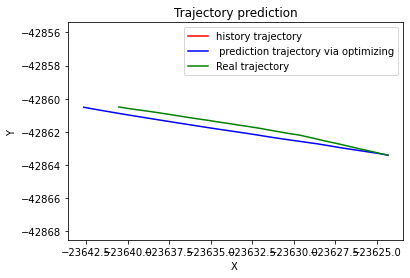

Test loss: 0.00806698974296673
MSE pre: 22.650556081139612
MSE RST: 0.767395609463731
ADE_rst: 1.152798281383116
FDE_rst: 1.4258896811061412
ADE_pre: 6.031575267549075
FDE_pre: 3.849981454222841


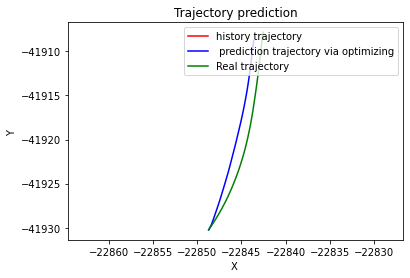

Test loss: 0.007557262228922257
MSE pre: 5.2765616506783415
MSE RST: 0.08108870910945087
ADE_rst: 0.2687400521721948
FDE_rst: 1.1695642112680453
ADE_pre: 3.0320322325481706
FDE_pre: 4.349476399764145


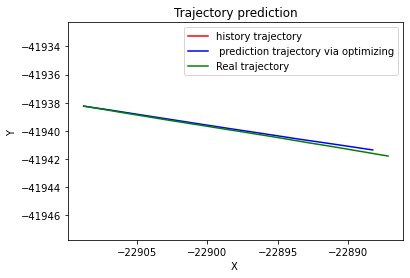

Test loss: 0.005885293663849811
MSE pre: 5.293361883010717
MSE RST: 0.09357755487002044
ADE_rst: 0.37622198488394204
FDE_rst: 0.7982861963532579
ADE_pre: 2.9178277201423843
FDE_pre: 5.909526024436181


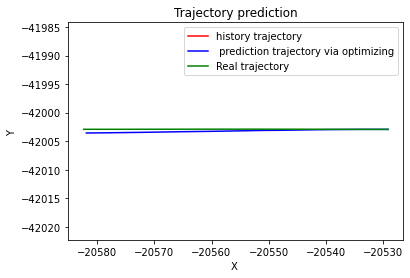

Test loss: 0.007723687276999786
MSE pre: 12.334052063206268
MSE RST: 0.2971343125697264
ADE_rst: 0.559945996728037
FDE_rst: 1.6136032687493929
ADE_pre: 4.5648491268429
FDE_pre: 4.8110682683476


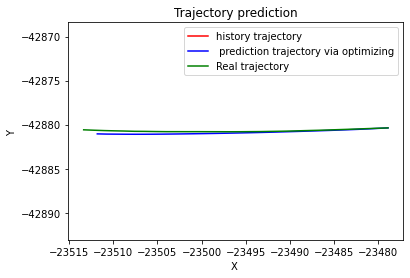

Test loss: 0.007961042656707648
MSE pre: 24.625464990739662
MSE RST: 0.6333401640291287
ADE_rst: 0.9642018521558919
FDE_rst: 1.4581830167233527
ADE_pre: 6.862850997679972
FDE_pre: 2.7915459341597044


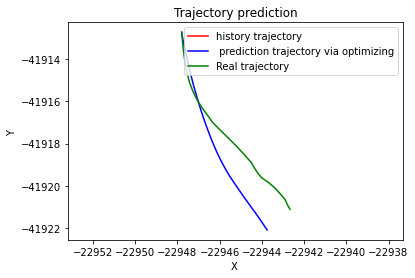

Test loss: 0.007834743825606253
MSE pre: 12.884158080132734
MSE RST: 0.11327082037416444
ADE_rst: 0.45348681625596
FDE_rst: 0.45707479649776234
ADE_pre: 4.761388383037496
FDE_pre: 5.291846903844898


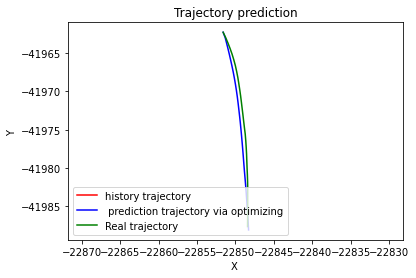

Test loss: 0.014750073637423743
MSE pre: 12.188841518847841
MSE RST: 0.7765817473907259
ADE_rst: 0.954700231324951
FDE_rst: 2.721932038989441
ADE_pre: 4.011641875461578
FDE_pre: 6.546553041330607


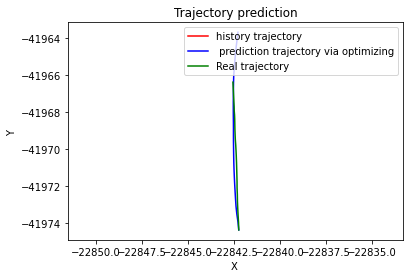

Test loss: 0.009218878432134483
MSE pre: 98.68152646446485
MSE RST: 0.44160111751082115
ADE_rst: 0.746245937732631
FDE_rst: 2.0096654939878342
ADE_pre: 13.959546483201425
FDE_pre: 12.302587067490999


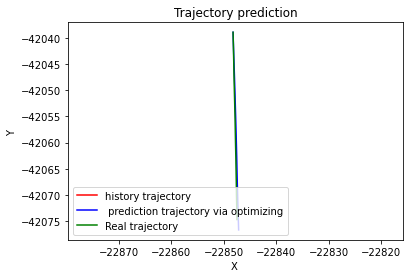

Test loss: 0.008711437832333026
MSE pre: 24.29052786836597
MSE RST: 0.10126228295564567
ADE_rst: 0.38221399697391184
FDE_rst: 0.692175400638085
ADE_pre: 6.831035852516318
FDE_pre: 8.117768686259312


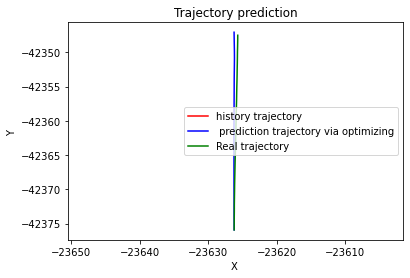

Test loss: 0.020768281318861263
MSE pre: 147.4072971985266
MSE RST: 0.04513242071973127
ADE_rst: 0.19971247341276224
FDE_rst: 0.7077410758728137
ADE_pre: 15.796733302292452
FDE_pre: 16.38866524343763


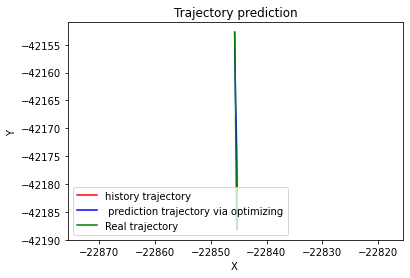

Test loss: 0.01427530810280425
MSE pre: 2.7517993901805506
MSE RST: 0.47725538262588624
ADE_rst: 0.8458841153936187
FDE_rst: 1.5803332464802995
ADE_pre: 2.1760053640043067
FDE_pre: 1.7824092519423393


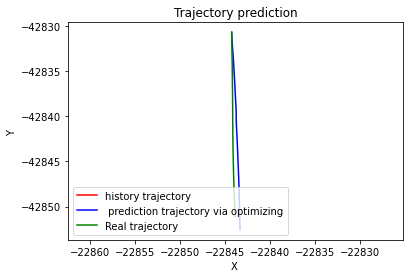

Test loss: 0.009557846993151807
MSE pre: 81.73220577758217
MSE RST: 0.034840013689011885
ADE_rst: 0.22298653019480272
FDE_rst: 0.34322007286467127
ADE_pre: 12.436667099925035
FDE_pre: 9.085744680154459


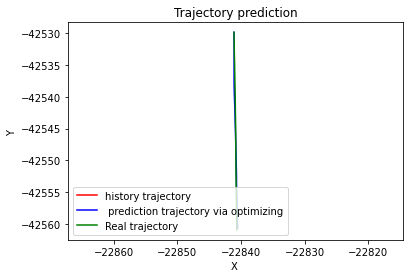

Test loss: 0.01184090560293966
MSE pre: 7.053288153779534
MSE RST: 0.08447423841264659
ADE_rst: 0.32686021387208636
FDE_rst: 1.0184409150505482
ADE_pre: 3.5411680756881516
FDE_pre: 5.940569124469589


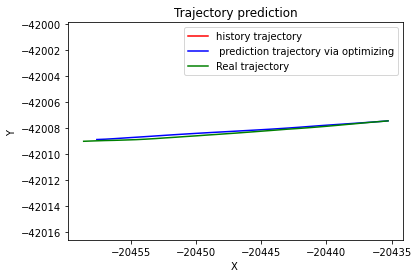

Test loss: 0.0065796904382826905
MSE pre: 15.688874794686992
MSE RST: 0.5258472823560457
ADE_rst: 0.8689027218447831
FDE_rst: 1.767324018197834
ADE_pre: 5.300828871497441
FDE_pre: 10.051801938344717


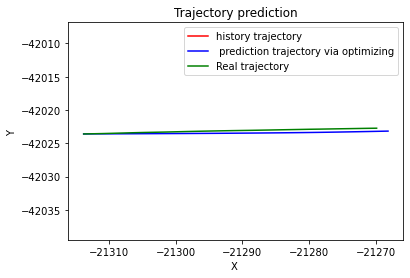

Test loss: 0.008869483807497766
MSE pre: 15.398815614437884
MSE RST: 0.0374146795273466
ADE_rst: 0.24573611272758636
FDE_rst: 0.4369647568284751
ADE_pre: 5.203578509428773
FDE_pre: 9.543264442705825


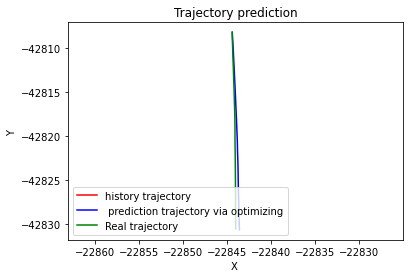

Test loss: 0.006938898080605021
MSE pre: 5.630933375860533
MSE RST: 0.2532595163412697
ADE_rst: 0.6134936674475001
FDE_rst: 0.6988079171125053
ADE_pre: 2.8414960738646027
FDE_pre: 9.903041915931599


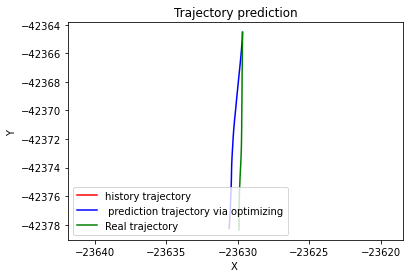

Test loss: 0.007503781917263049
MSE pre: 18.509330695700687
MSE RST: 0.14414468942243258
ADE_rst: 0.46659787133358516
FDE_rst: 0.9107804150730038
ADE_pre: 5.878070953195947
FDE_pre: 7.933048884978438


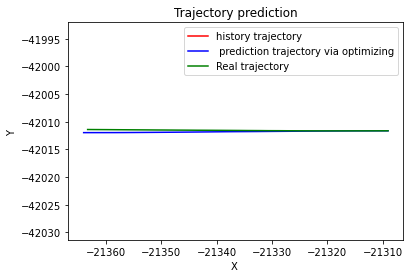

Test loss: 0.008337608320902145
MSE pre: 13.159384832922353
MSE RST: 0.3655936051655494
ADE_rst: 0.6698219319801104
FDE_rst: 2.2629689141679314
ADE_pre: 4.609738294908623
FDE_pre: 2.5445363605054574


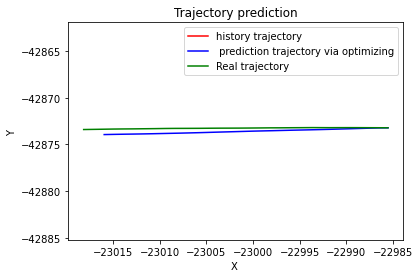

Test loss: 0.01027644944796782
MSE pre: 28.237319236109887
MSE RST: 1.0540954186917153
ADE_rst: 1.265146051684197
FDE_rst: 2.4180325011555426
ADE_pre: 6.770235727465405
FDE_pre: 15.803006665457284


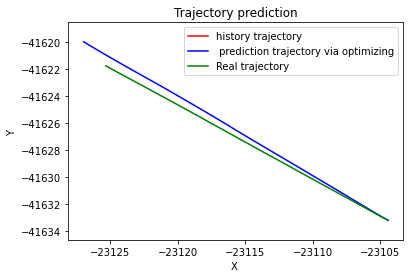

Test loss: 0.008640088628251542
MSE pre: 8.53341628098092
MSE RST: 0.10435453368463203
ADE_rst: 0.42498577894924233
FDE_rst: 0.45225193432861016
ADE_pre: 4.032618610013478
FDE_pre: 2.6676827071936473


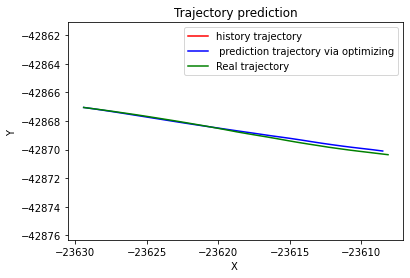

Test loss: 0.0061673816483812345
MSE pre: 38.915988300794055
MSE RST: 0.20857859932379555
ADE_rst: 0.527577116112657
FDE_rst: 1.220963690181176
ADE_pre: 8.372060141186992
FDE_pre: 5.032500856266257


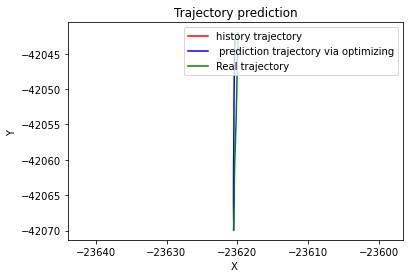

Test loss: 0.006838527980130281
MSE pre: 13.666103768520472
MSE RST: 0.1758739379590548
ADE_rst: 0.5394311200911012
FDE_rst: 0.7254387052585904
ADE_pre: 4.892536259138248
FDE_pre: 3.6919927953751257


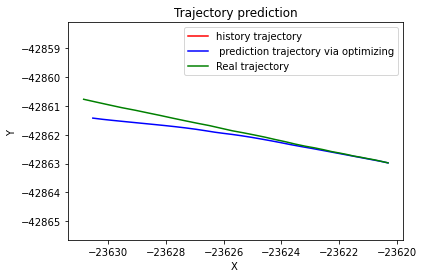

Test loss: 0.012995098281142599
MSE pre: 45.60238800728081
MSE RST: 3.8781798745264706
ADE_rst: 2.1472123294619583
FDE_rst: 5.826098087783243
ADE_pre: 7.854599601892853
FDE_pre: 26.633892579501033


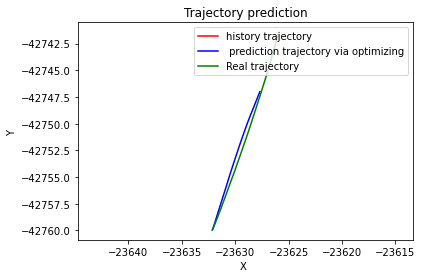

Test loss: 0.008378459333139994
MSE pre: 27.386804850040686
MSE RST: 1.3732824968974384
ADE_rst: 1.3569074775295948
FDE_rst: 3.2713010923035872
ADE_pre: 7.000469868937958
FDE_pre: 10.534843641419629


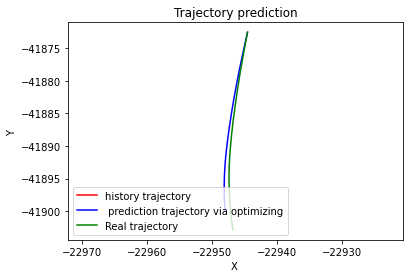

Test loss: 0.008828088587972568
MSE pre: 16.228282449400314
MSE RST: 0.28905442619922395
ADE_rst: 0.6591147222060837
FDE_rst: 1.3377524155979548
ADE_pre: 5.300123245113665
FDE_pre: 3.039660110935246


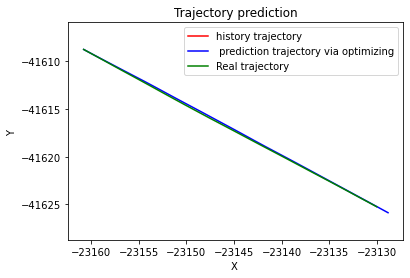

Test loss: 0.007327865027204476
MSE pre: 14.74573084952902
MSE RST: 0.5072717193934185
ADE_rst: 0.8913656613009162
FDE_rst: 1.5867879278920964
ADE_pre: 4.438320266406228
FDE_pre: 12.096278273647188


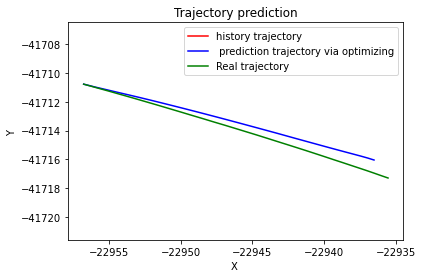

Test loss: 0.007028397258565372
MSE pre: 7.952600712221185
MSE RST: 0.6170935494546704
ADE_rst: 0.8655799665701119
FDE_rst: 2.3554311680303606
ADE_pre: 3.6746773655480287
FDE_pre: 5.703183214631696


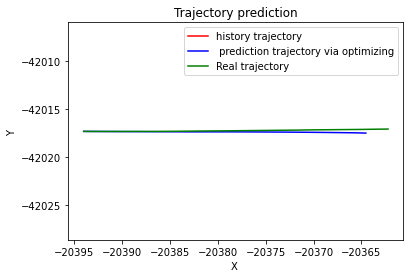

Test loss: 0.007082039184015247
MSE pre: 5.9238205537690805
MSE RST: 0.4386050174846168
ADE_rst: 0.759279866223996
FDE_rst: 1.5468427593439433
ADE_pre: 3.20986038494218
FDE_pre: 8.74715689430053


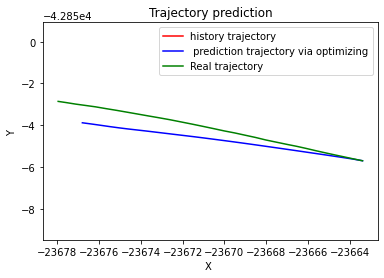

Test loss: 0.007634740026058886
MSE pre: 2.7446613009078304
MSE RST: 0.49597006421149586
ADE_rst: 0.7523670508287209
FDE_rst: 1.9828613187008859
ADE_pre: 2.0170262154197443
FDE_pre: 4.280572553540007


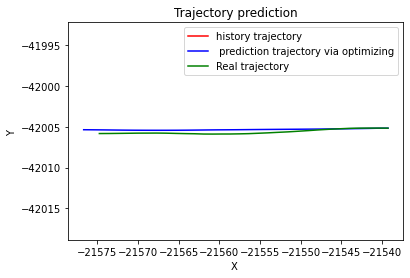

Test loss: 0.00785938182314522
MSE pre: 9.176068198072372
MSE RST: 0.23157465299028926
ADE_rst: 0.4012089637547025
FDE_rst: 1.9693884309621796
ADE_pre: 4.1401506514210835
FDE_pre: 4.4864774522504725


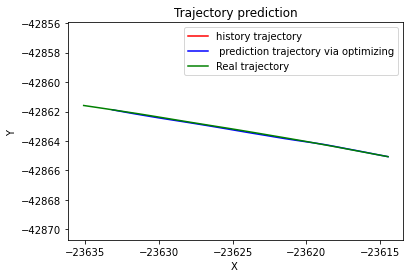

Test loss: 0.007517142598863706
MSE pre: 33.57365137058361
MSE RST: 1.2081714079220118
ADE_rst: 1.4426620127487804
FDE_rst: 2.064483611319999
ADE_pre: 7.437440741772393
FDE_pre: 7.5582684700027905


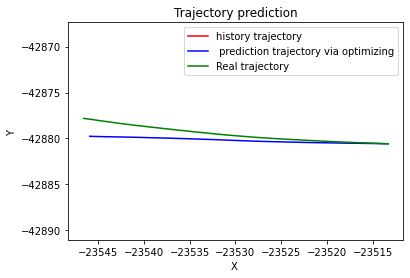

Test loss: 0.008305563379529719
MSE pre: 7.65347786001955
MSE RST: 0.27405527965892923
ADE_rst: 0.6090725231678714
FDE_rst: 1.2840393137607367
ADE_pre: 3.700247792607667
FDE_pre: 3.5579805299300813


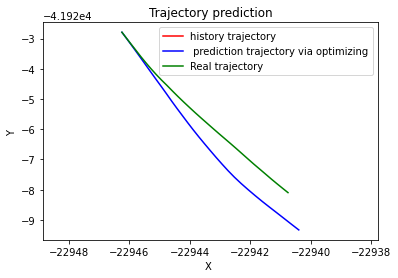

Test loss: 0.009376443102639628
MSE pre: 12.26564930956723
MSE RST: 0.06217327716832837
ADE_rst: 0.30999125718991277
FDE_rst: 0.6118848579570293
ADE_pre: 4.753581828883951
FDE_pre: 4.536033333617008


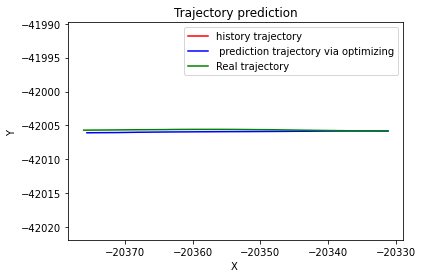

Test loss: 0.006673418285486612
MSE pre: 36.737517440018216
MSE RST: 0.3449392896206108
ADE_rst: 0.7307849150589654
FDE_rst: 1.365852225205849
ADE_pre: 8.133212830955019
FDE_pre: 17.793545620435903


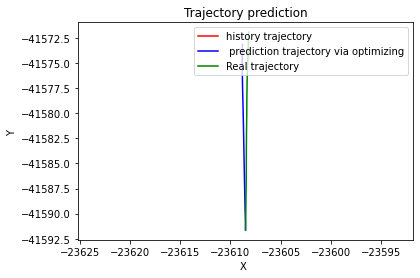

Test loss: 0.009022133958788696
MSE pre: 6.175905466283255
MSE RST: 0.014265494411345144
ADE_rst: 0.15694680980434422
FDE_rst: 0.3475270213332605
ADE_pre: 3.232139712087399
FDE_pre: 3.256944078205569


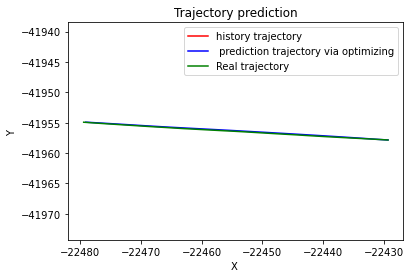

Test loss: 0.005994246605299587
MSE pre: 25.309170537099178
MSE RST: 0.08158298922513073
ADE_rst: 0.3682103006320569
FDE_rst: 0.5795423999234746
ADE_pre: 6.688095748819285
FDE_pre: 5.771917016094793


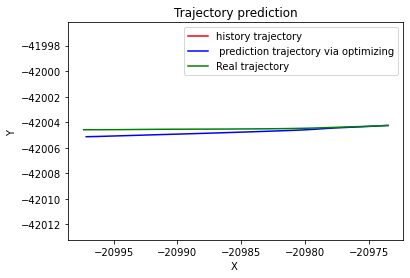

Test loss: 0.008303532773924316
MSE pre: 17.09884208652753
MSE RST: 0.45690963043566013
ADE_rst: 0.5975202264396832
FDE_rst: 2.604404770869255
ADE_pre: 5.4839752990826325
FDE_pre: 6.547174060114589


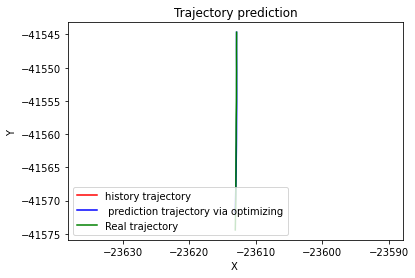

Test loss: 0.009498314328320205
MSE pre: 20.516841799695413
MSE RST: 0.7702777369180152
ADE_rst: 1.1155732038781803
FDE_rst: 1.9558993719329645
ADE_pre: 5.698551836330291
FDE_pre: 0.521551437793685


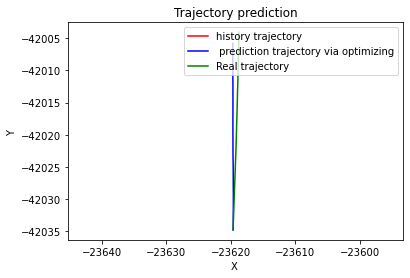

Test loss: 0.006765091408456697
MSE pre: 2.613962943218107
MSE RST: 0.8458828044427436
ADE_rst: 1.0725202549932
FDE_rst: 2.4639899864223347
ADE_pre: 2.185922936921638
FDE_pre: 2.659800752583306


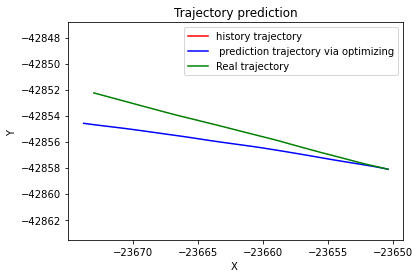

Test loss: 0.014828827140678633
MSE pre: 28.760844460271116
MSE RST: 0.7428434271272342
ADE_rst: 1.145068354434127
FDE_rst: 2.0340494588330933
ADE_pre: 7.213625069834814
FDE_pre: 3.4666277273267116


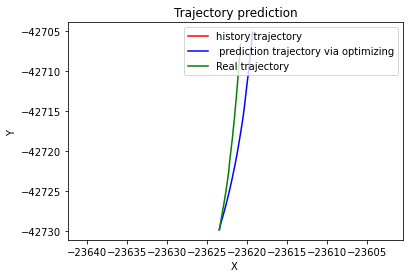

Test loss: 0.007082352931942867
MSE pre: 30.503944818323298
MSE RST: 0.8586978531891055
ADE_rst: 1.00341487072914
FDE_rst: 3.3176147854932507
ADE_pre: 7.647726871976858
FDE_pre: 12.804250771986645


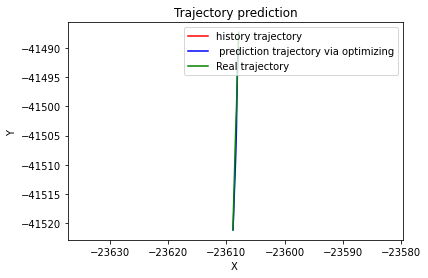

Test loss: 0.009615005016822246
MSE pre: 46.441912203296205
MSE RST: 0.4426926833302366
ADE_rst: 0.6396920761209683
FDE_rst: 2.212423688107795
ADE_pre: 9.236090648414246
FDE_pre: 12.885898334516023


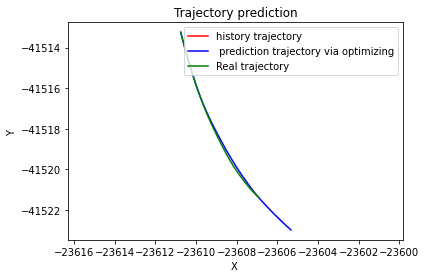

Test loss: 0.009875242972486703
MSE pre: 41.48218390500083
MSE RST: 0.2373291700377818
ADE_rst: 0.5766719715821812
FDE_rst: 1.158751432826971
ADE_pre: 8.557862226815029
FDE_pre: 3.1238273389781734


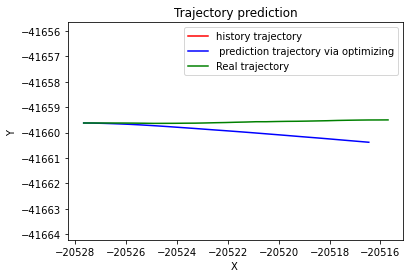

Test loss: 0.008551230239884218
MSE pre: 91.09185730023226
MSE RST: 0.984848368093902
ADE_rst: 1.2646900330949944
FDE_rst: 2.0417409882088964
ADE_pre: 11.319547243803095
FDE_pre: 37.43519168113135


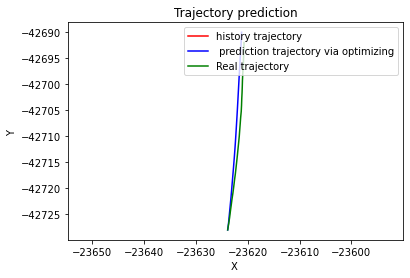

Test loss: 0.009240945339333355
MSE pre: 31.74523729608664
MSE RST: 0.3552286837341582
ADE_rst: 0.718220255384795
FDE_rst: 1.4801676739371445
ADE_pre: 7.909536193502196
FDE_pre: 11.997241917458533


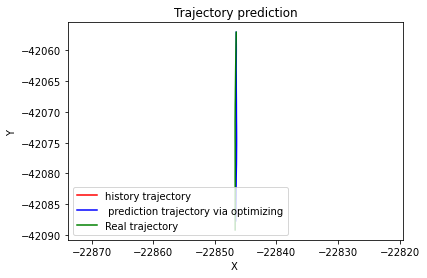

Test loss: 0.007617908705330854
MSE pre: 41.40835873959439
MSE RST: 2.5477136283104644
ADE_rst: 1.497834349886485
FDE_rst: 5.617374913625565
ADE_pre: 8.185985209729491
FDE_pre: 10.41931908957907


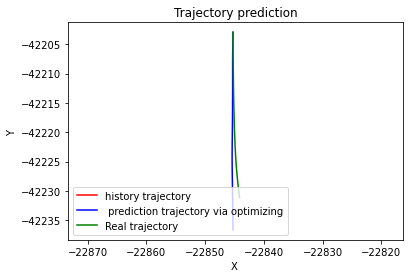

Test loss: 0.009822943523178801
MSE pre: 32.208391828495685
MSE RST: 0.26995860920461423
ADE_rst: 0.6372653427256627
FDE_rst: 1.1409494030223295
ADE_pre: 7.481855344040689
FDE_pre: 9.515505910234495


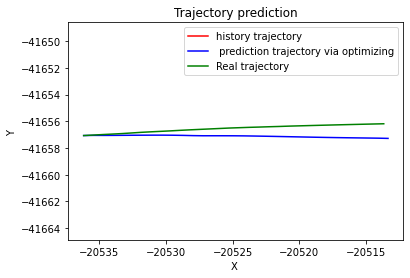

Test loss: 0.008028393624773226
MSE pre: 10.462131467882498
MSE RST: 0.06072495203181296
ADE_rst: 0.3121794231266376
FDE_rst: 0.5811562957760782
ADE_pre: 4.459623936047156
FDE_pre: 5.188312184303315


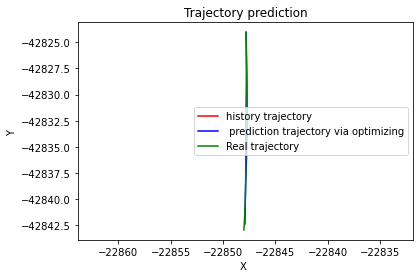

Test loss: 0.007623725543023232
MSE pre: 15.625223031058095
MSE RST: 3.594700619157361
ADE_rst: 2.1896193231286856
FDE_rst: 4.963183696275937
ADE_pre: 4.410525616054766
FDE_pre: 10.251909863005714


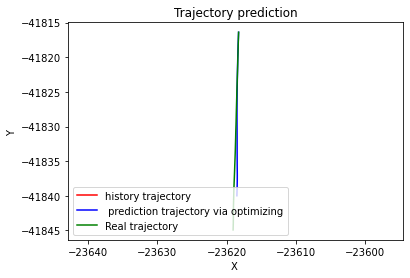

Test loss: 0.00826513002685362
MSE pre: 12.750263275085949
MSE RST: 1.0448633592934944
ADE_rst: 1.0460909267737082
FDE_rst: 3.2660748323720252
ADE_pre: 4.834374686696258
FDE_pre: 9.680700652686529


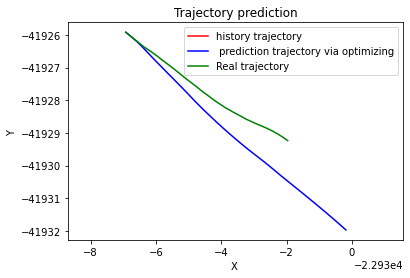

Test loss: 0.014015518456052069
MSE pre: 118.40251061990978
MSE RST: 0.3992429251096429
ADE_rst: 0.7900771751512745
FDE_rst: 1.5280551480196982
ADE_pre: 15.01238468599319
FDE_pre: 13.302288982769142


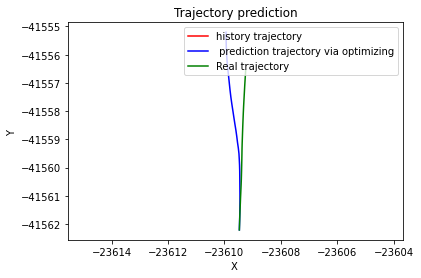

Test loss: 0.005814210307566225
average MSE_pre: 33.10993957115226
average MSE_rst: 0.9774226439344255
average ADE_rst: 0.9445856193216857
average FDE_rst: 2.0932224410809432
average ADE_pre: 6.497907810051528
average FDE_pre: 7.289560500260308
average loss: 0.008952558640911618


In [12]:
hidden_size = 64
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_0114_43_4_30_new.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
Eval_net(Prednet, True)

In [13]:
def predict(model,test_load,n,optimizer=False):
    test = iter(test_load)
    x,y =  test.next()
    x,y = x.to(device),y.to(device)
    model.eval()
    predY = model(x)
    criterion = nn.MSELoss()
    test_loss = criterion(predY,y)
    std = WholeSet.std.repeat(x.shape[0],x.shape[1],1)
    std = std[:,:,:4].to(device)
    mn = WholeSet.mn.repeat(x.shape[0],x.shape[1],1)
    mn = mn[:,:,:4].to(device)
    rg = WholeSet.range.repeat(x.shape[0],x.shape[1],1)
    rg = rg[:,:,:4].to(device)
    predY = (predY*(rg*std)+mn).detach().cpu()
    pY = np.array(predY)
    local_labels = (y*(rg*std)+mn).detach().cpu()
    Y = np.array(local_labels)
    pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
    rst_xy = calcu_XY(pY)
    real_predict = torch.from_numpy(Y[:n,-predict_length-1:,2:4])
    rst_predict = torch.from_numpy(rst_xy[:n,-predict_length-1:,:2])
    pre_predict = torch.from_numpy(pY[:n,-predict_length-1:,2:4])
    MSE_pre = criterion(real_predict,pre_predict)
    MSE_rst = criterion(real_predict,rst_predict)
    print("MSE pre:",MSE_pre.item())
    print("MSE RST:",MSE_rst.item())
    plt.plot(Y[:n,:-predict_length,2][0],Y[:n,:-predict_length,3][0],'r',label = 'history trajectory')
    if optimizer:
        plt.plot(rst_xy[:n,-predict_length-1:,0][0],rst_xy[:n,-predict_length-1:,1][0],'b',label="prediction trajectory via optimizing")
#     plt.plot(pY[:n,-predict_length-1:,2][0],pY[:n,-predict_length-1:,3][0],'k',label='prediction trajectory')
    plt.plot(Y[:n,-predict_length-1:,2][0],Y[:n,-predict_length-1:,3][0],'g',label='Real trajectory')
    plt.title('Trajectory prediction')
    plt.xlabel('X ')
    plt.ylabel('Y ')
    plt.axis('equal')
    plt.legend()
    if optimizer:
        plt.savefig("image/trajectory_output_optimization/trajectory_alone.svg",dpi = 600)
    else:
        plt.savefig("image/trajectory_output/trajectory_alone.svg",dpi = 600)
    
    print("Test Loss:",test_loss.item())

torch.Size([128, 31, 43])
MSE pre: 30.74485543905931
MSE RST: 1.194240073866076
Test Loss: 0.00848829736776152


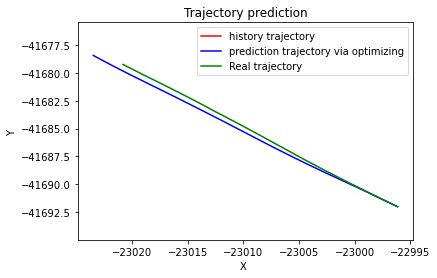

In [17]:
hidden_size = 64
print(x.shape)
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_0114_43_4_30_new.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
predict(Prednet, Test, 1, True)

In [11]:
test_iter = iter(Test)
x, y = test_iter.next()
print(x.shape)
x,y = x.to(device),y.to(device)
x = x[0][0].view(-1,len(x[0][0])).unsqueeze(0)
predY = Prednet(x)
print(predY)
print(y[0][2])

torch.Size([128, 31, 43])
tensor([[[ 0.6521,  0.0794, -0.0870,  0.5168]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([ 0.5023,  0.0898, -0.0880,  0.5162], device='cuda:0',
       dtype=torch.float64)


In [18]:
Prednet.load_state_dict(torch.load('model/trajectory_predict_0114_43_4_30_new.pt'))
Prednet.cuda().eval()
from time import time
# An example input you would normally provide to your model's forward() method.
#example = torch.rand(1, 4)

example = torch.ones(1,31,43).double().cuda()
t = time()
out = Prednet(example)
print('time',(time()-t)*1000)
print(out)
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(Prednet, example)
traced_script_module.save("model/trajectory_prediction_LSTM_0114_31_30_cuda.pt")
example1 = torch.zeros(1,31,43).double().cuda()
out = traced_script_module(example)
out1 = traced_script_module(example1)
print(out)
#print(out1)

time 10.403633117675781
tensor([[[0.8702, 1.6243, 0.9685, 1.1482],
         [0.8329, 1.6759, 0.9615, 1.1626],
         [0.8016, 1.7076, 0.9595, 1.1781],
         [0.7782, 1.7332, 0.9610, 1.1886],
         [0.7643, 1.7528, 0.9641, 1.1954],
         [0.7564, 1.7672, 0.9676, 1.2004],
         [0.7514, 1.7782, 0.9708, 1.2045],
         [0.7472, 1.7871, 0.9736, 1.2080],
         [0.7427, 1.7951, 0.9761, 1.2110],
         [0.7372, 1.8029, 0.9781, 1.2138],
         [0.7304, 1.8110, 0.9799, 1.2163],
         [0.7223, 1.8198, 0.9813, 1.2187],
         [0.7126, 1.8294, 0.9825, 1.2208],
         [0.7014, 1.8399, 0.9835, 1.2228],
         [0.6886, 1.8513, 0.9844, 1.2247],
         [0.6741, 1.8635, 0.9851, 1.2264],
         [0.6578, 1.8766, 0.9858, 1.2279],
         [0.6395, 1.8906, 0.9864, 1.2292],
         [0.6189, 1.9053, 0.9870, 1.2302],
         [0.5957, 1.9210, 0.9876, 1.2309],
         [0.5694, 1.9376, 0.9883, 1.2311],
         [0.5397, 1.9550, 0.9891, 1.2308],
         [0.5064, 1.9727, 0.99

In [13]:
import numpy as np
std = WholeSet_train.std.detach().cpu().numpy()    
mn = WholeSet_train.mn.detach().cpu().numpy() 
print(mn)
#rg = WholeSet_train.range.detach().cpu().numpy()    
#np.savetxt("std.txt", std)
#np.savetxt("mean.txt", mn)
#np.savetxt("rg.txt", rg)
m= torch.from_numpy(np.loadtxt('mean.txt'))
print(m)

[ 6.75118515e-01 -6.49453829e-01 -2.27846678e+04 -4.21421099e+04
  8.35478883e+00  2.61211556e-02 -2.81239278e-02 -1.04840903e+00
 -4.42301211e+00  4.66435161e+00  1.41703086e+00  8.40191559e-03
 -2.58998793e-01 -9.78175015e-01  4.08652899e+00  4.31678855e+00
  1.35872344e+00  1.26075021e-02 -2.34929517e-01  2.22529777e-02
 -6.55926642e+00  6.57110785e+00  1.96451567e+00  6.65455234e-03
  1.23370118e-03  5.93764499e-02  6.23357404e+00  6.24639411e+00
  1.87826875e+00  1.05690945e-02  3.56244772e-02  1.06779971e+00
 -4.49116522e+00  4.74175295e+00  1.28404156e+00  9.35965955e-03
  2.17534460e-01  1.07416996e+00  4.43973892e+00  4.70448066e+00
  1.29446112e+00  7.21403978e-03  1.97882094e-01]
tensor([ 6.7512e-01, -6.4945e-01, -2.2785e+04, -4.2142e+04,  8.3548e+00,
         2.6121e-02, -2.8124e-02, -1.0484e+00, -4.4230e+00,  4.6644e+00,
         1.4170e+00,  8.4019e-03, -2.5900e-01, -9.7818e-01,  4.0865e+00,
         4.3168e+00,  1.3587e+00,  1.2608e-02, -2.3493e-01,  2.2253e-02,
        